# Estimate population parameters

...by computing the likelihood on a grid.

Notation:
* $p = \{\mathcal{M}, q, \chi_{\rm eff}, \ldots \}$ are the physical parameters of the merger, `p_params`.
* $\mu$ are the population-model parameters, `mu_params`.
* $R(p, \mu)$ are modeled universe-rates, so that $R(p, \mu){\rm d}p$ has units of $(VT)^{-1}$.
* $\lambda(p, \mu) = V(p) R(p, \mu)$ are the detector-rates, where $V(p)$ is the detector network sensitive volume averaged over angles (in practice, $\propto {\rm SNR_{1Mpc}^3}$).
* $\overline\lambda(\mu) = \int {\rm d}p V(p) R(p, \mu)$ is the total detector-rate.
* $r(p, \mu) = \lambda(p, \mu) / \overline\lambda(\mu)$ are the *relative* detector-rates, normalized so that $\int r(p, \mu){\rm d}p = 1$.
* $\mathcal{L}_i(p)$ is the likelihood that the $i$-th GW event has parameters $p$, normalized to $\int \mathcal{L}_i(p){\rm d}p = 1$.

$$P({\rm data \mid model}, \mu) \propto \prod_{i \in \rm \{events\}} \int {\rm d}p ~ r(p, \mu) \mathcal{L}_i(p)$$

In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from scipy.interpolate import UnivariateSpline
from scipy.optimize import brentq as brentq
from scipy.special import erf
from numpy import sqrt, pi
from collections import OrderedDict

In [2]:
events = ['GW150914',
          'GW151226',
          'LVT151012',
          'GW170104',
          'GW170608',
          'GW170814'
         ]

approximants = ['IMRPhenomD',
                'SEOBNRv4_ROM'
               ]
PSDs = ['ASD_H1_GW150914', 'ASD_zdhp']
coherences = ['coherent', 'incoherent']

In [3]:
PSDs_coherences_approximants = [(PSD, coherence, approximant) for PSD in PSDs 
                                                              for coherence in coherences
                                                              for approximant in approximants]

coherences_approximants = [(coherence, approximant) for coherence in coherences 
                                                    for approximant in approximants]

PSDs_approximants = [(psd, approximant) for psd in PSDs
                     for approximant in approximants]

## Load
* Grid in $p$-space for each event $i$, including $\log \mathcal{L}_i(p)$  
Compute the likelihood, normalize to $\int \mathcal{L}_i(p){\rm d}p = 1$.

* Sensitive volume $V(p) \propto {\rm SNR}_{1 \rm Mpc}^3$ on a full $p$-grid  
Interpolate $V(p)$ on the $p$-space grids of each event.

In [4]:
p_grid = {}
for event in events:
    p_grid[event] = pd.read_csv(event + '/parameter_grid', sep='\s+')
    for CA in coherences_approximants:
        L = np.exp(p_grid[event]['logL_' + '_'.join(CA)])
        L /= L.sum()
        if event == 'LVT151012':
            L = .87*L + .13  # Marginalize over the possibility that LVT is noise
        p_grid[event]['likelihood_' + '_'.join(CA)] = L

In [5]:
# Load SNR_1Mpc on full p-grid
p_params = ['M_chirp', 'q', 'chi_eff']
p_grid['full'] = pd.read_csv('../2-estimate_horizon/all_par_space/parameter_grid', sep='\s+')
metadata = pd.read_csv('../2-estimate_horizon/all_par_space/grid_metadata', sep='\s+')
p_grid_1d = {par: np.sort(list(set(p_grid['full'][par].values))) for par in p_params}  # Of the full p-grid

assert all(p_par in grid for p_par in p_params for grid in p_grid.values())
assert all(metadata.columns == p_params)

In [6]:
# Interpolate over each event's grid, and also refine the full p_grid => p_igrid
min_val, max_val = ({p_par: f(p_grid['full'][p_par]) for p_par in p_params} for f in (min, max))
zoom = 4
p_igrid_1d = {p_par: np.linspace(min_val[p_par], max_val[p_par], zoom * metadata[p_par][0]) for p_par in p_params}
p_igrid = OrderedDict(zip(p_params, np.meshgrid(*[p_igrid_1d[p_par] for p_par in p_params], indexing='ij')))
for PA in PSDs_approximants:
    V = p_grid['full']['SNR_1Mpc_' + '_'.join(PA)].values.reshape(metadata.values[0])**3
    for event in events:
        p_grid[event]['V_' + '_'.join(PA)] = ndimage.map_coordinates(
            V, [(p_grid[event][p_par] - min_val[p_par]) * (
                (metadata[p_par][0]-1) / (max_val[p_par]-min_val[p_par])) for p_par in p_params])
    p_igrid[(*PA), 'V'] = ndimage.zoom(V, zoom, order=1)

## Model physical rates

Define some rate models, that return the physical rate $R(p, \mu)$. The only important information is the ratio $R(p_1, \mu) / R(p_2,\mu)$ for the same $\mu$. Normalization is otherwise arbitrary.

### Models on spin

In [34]:
def simple_chi_eff(chi_eff, alpha, **kwargs):
    return np.exp(alpha * chi_eff)
simple_chi_eff.latex = r'$R(\chi_{\rm eff}) \propto e^{\alpha \chi_{\rm eff}}$'
simple_chi_eff.p_params = ['chi_eff']
simple_chi_eff.mu_params = ['alpha']
simple_chi_eff.mu_bounds = {'alpha': [-5, 5]}

def exponential_chi_eff(chi_eff, avg_chi_eff, **kwargs):
    abs_avg = abs(avg_chi_eff)
    alpha = (np.sign(avg_chi_eff) 
             * brentq(lambda a: 1/np.tanh(a) - 1/a - abs_avg, 3*abs_avg, 3 * (1/(1-abs_avg) - 1)))
    assert(np.sign(avg_chi_eff) == np.sign(alpha))
    return np.exp(alpha * chi_eff)
exponential_chi_eff.latex = r'$R(\chi_{\rm eff}) \propto e^{\alpha \chi_{\rm eff}}$'
exponential_chi_eff.p_params = ['chi_eff']
exponential_chi_eff.mu_params = ['avg_chi_eff']
exponential_chi_eff.mu_bounds = {'avg_chi_eff': [-.99, .99]}

def both_spinning(q, chi_eff, alpha1, alpha2, **kwargs):
    # A rustic but fast piecewise function:
    cond1 = 1 + chi_eff + q*chi_eff <= q
    cond2 = q + chi_eff + q*chi_eff > 1
    cond3 = ~ (cond1 | cond2)  # Neither
    with np.errstate(divide='ignore', invalid='ignore'):
        R = np.divide( 
            cond1 * (np.exp(-alpha1 - alpha2)*(np.exp((1 + q)*alpha1*(1 + chi_eff))
                     - np.exp(((1 + q)*alpha2*(1 + chi_eff))/q))*(1 + q))
            + cond2 * (np.exp(-alpha1 - alpha2) * (-np.exp(2*alpha2 + alpha1*(1 + q*(-1 + chi_eff) + chi_eff))
                       +np.exp(2*alpha1 + (alpha2*(-1 + q + chi_eff + q*chi_eff))/q))*(1+q))
            + cond3 * (2*np.exp((1 + q)*alpha1*chi_eff)*(1 + q)*np.sinh(q*alpha1 - alpha2))
            , (q*alpha1 - alpha2))
    R[np.isinf(R) | np.isnan(R)] = 0  # Exclude nans and infs
    return R
both_spinning.latex = r'$R(\chi_i) \propto e^{\alpha_i \chi_i}$'
both_spinning.p_params = ['q', 'chi_eff']
both_spinning.mu_params = ['alpha1', 'alpha2']
both_spinning.mu_bounds = {'alpha1': [-5, 5],
                           'alpha2': [-5, 5]}

def zero_mean_gaussian_chi_eff(chi_eff, std_chi_eff, **kwargs):
    return np.exp(-.5 * chi_eff**2 / std_chi_eff**2)
zero_mean_gaussian_chi_eff.latex = (r'$R(\chi_{\rm eff}) \propto '
                                    r'\exp(-\chi_{\rm eff}^2 / 2 \sigma_{\chi_{\rm eff}}^2)}$')
zero_mean_gaussian_chi_eff.p_params = ['chi_eff']
zero_mean_gaussian_chi_eff.mu_params = ['std_chi_eff']
zero_mean_gaussian_chi_eff.mu_bounds = {'std_chi_eff': [5e-3, .5]}

def gaussian_chi_eff(chi_eff, mean_chi_eff, std_chi_eff, **kwargs):
    return np.exp(-(chi_eff - mean_chi_eff)**2 / std_chi_eff**2 / 2)
gaussian_chi_eff.latex = (r'$R(\chi_{\rm eff}) \propto \exp \left('
    r'-(\chi_{\rm eff}-\overline{\chi}_{\rm eff})^2 / 2 \sigma_{\chi_{\rm eff}}^2 \right)$')
gaussian_chi_eff.p_params = ['chi_eff']
gaussian_chi_eff.mu_params = ['mean_chi_eff', 'std_chi_eff']
gaussian_chi_eff.mu_bounds = {'mean_chi_eff': [-.3, .3],
                              'std_chi_eff': [5e-3, .45]}

def gaussian_2ndlocked_chi_eff(q, chi_eff, std_chi_eff, f, **kwargs):
    '''A zero-mean gaussian population * (1-f), plus a secondary-locked population * f.'''
    return ((1-f) * np.exp(-chi_eff**2 / std_chi_eff**2 / 2)
            + f * sqrt(1+q**2) * np.exp(-(chi_eff-q/(1+q))**2 * (1+q**2) / std_chi_eff**2 / 2))
gaussian_2ndlocked_chi_eff.latex = (r'$R(\chi_{\rm eff}, q) \propto'
    r'(1-f) G(\chi_{\rm eff}, \sigma_{\chi_{\rm eff}})'
    r'+ f \, G(\chi_{\rm eff} - \frac{q}{1+q}, \frac{\sigma_{\chi_{\rm eff}}}{\sqrt{1+q^2}})$')
gaussian_2ndlocked_chi_eff.p_params = ['q', 'chi_eff']
gaussian_2ndlocked_chi_eff.mu_params = ['f', 'std_chi_eff']
gaussian_2ndlocked_chi_eff.mu_bounds = {'f': [0, 1],
                                        'std_chi_eff': [1e-2, .4]}

def gaussian_2ndlocked_chi_eff_old(q, chi_eff, std_chi_eff, f, **kwargs):
    '''Like above but assuming the primary is non-spinning for the locked case.'''
    width_chi_eff = 5e-2  # The width of the 'delta function'
    return ((1-f) * np.exp(-chi_eff**2 / std_chi_eff**2 / 2) 
                  / (sqrt(2*pi) * std_chi_eff * erf(1/(sqrt(2)*std_chi_eff)))
            + f * (np.abs(chi_eff - q/(1+q)) < width_chi_eff)) / width_chi_eff
gaussian_2ndlocked_chi_eff_old.latex = (r'$R(\chi_{\rm eff}, q) \propto'
    r'(1-f) G (\chi_{\rm eff}, \sigma_{\chi_{\rm eff}})'
    r'+ f \, \delta(\chi_{\rm eff} - \frac{q}{1+q})$')
gaussian_2ndlocked_chi_eff_old.p_params = ['q', 'chi_eff']
gaussian_2ndlocked_chi_eff_old.mu_params = ['f', 'std_chi_eff']
gaussian_2ndlocked_chi_eff_old.mu_bounds = {'f': [0, 1],
                                        'std_chi_eff': [1e-2, .4]}

### Models on mass

In [8]:
def M_chirp_power_law_cutoff(M_chirp, alpha, Mchirp_max, Mchirp_min=5, **kwargs):
    if alpha == 0: alpha = 1e-10  # 0 is problematic
    return M_chirp**-alpha * (5 < M_chirp) * (M_chirp < Mchirp_max)
M_chirp_power_law_cutoff.latex = (r'$R(\mathcal{{M}}) \propto \mathcal{{M}}^{{-\alpha}}$, '
                                  r'$\mathcal{{M}} \in (5 M_\odot, \mathcal{{M}}_{{\rm max}})$')
M_chirp_power_law_cutoff.p_params = ['M_chirp']
M_chirp_power_law_cutoff.mu_params = ['alpha', 'Mchirp_max']
M_chirp_power_law_cutoff.mu_bounds = {'alpha': [-3, 5],
                                      'Mchirp_max': [25, 100]}

### Models on mass ratio

In [9]:
def q_power_law(q, q_avg, **kwargs):
    return q ** ((2*q_avg-1) / (1-q_avg))
q_power_law.latex = r'$R(q) \propto q^\alpha$'
q_power_law.p_params = ['q']
q_power_law.mu_params = ['q_avg']
q_power_law.mu_bounds = {'q_avg': [0, .99]}

In [32]:
latex = {'M_chirp': r'$\mathcal{{M}}$',
         'q': r'$q$',
         'chi_eff': r'$\chi_{{\rm eff}}$',
         'alpha': r'$\alpha$',
         'beta': r'$\beta$',
         'alpha1': r'$\alpha_1$',
         'alpha2': r'$\alpha_2$',
         'Mchirp_max': r'$\mathcal{M}_{\rm max}$',
         'mean_chi_eff': r'$\overline{{\chi}}_{\rm eff}$',
         'std_chi_eff': r'$\sigma_{\chi_{\rm eff}}$',
         'f': '$f$',
         'q_avg': r'$\langle q \rangle$',
         'avg_chi_eff': r'$\langle \chi_{{\rm eff}} \rangle$',
        }
unit = {par: r' (${\rm M}_\odot$)' if par in ['M_chirp', 'Mchirp_max'] else '' for par in latex}

In [35]:
models = [simple_chi_eff,
          exponential_chi_eff,
          both_spinning,
          M_chirp_power_law_cutoff,
          zero_mean_gaussian_chi_eff,
          gaussian_chi_eff,
          gaussian_2ndlocked_chi_eff,
          gaussian_2ndlocked_chi_eff_old,
          q_power_law,
         ]
assert all(par in p_params for model in models for par in model.p_params)
for model in models:
    model.p_params.sort(key=lambda par: p_params.index(par))  # Make sure they are in the same order as p_params
    model.name = model.__name__  # Easier

### Set up the grids
...in $\bf \mu$-space for each model, define the interpolation grids for later as well:

In [12]:
num_mu_grid = {(model.name, mu_par): 32 for model in models for mu_par in model.mu_params}  # Default
num_mu_grid['M_chirp_power_law_cutoff', 'Mchirp_max'] = 64  # Edit individual parameter numpoints
for model in models:
    if len(model.mu_params) == 1:  # Cheap ones
        num_mu_grid[model.name, model.mu_params[0]] = 64

mu_grid, mu_grid_1d = OrderedDict(), OrderedDict()
for model in models:
    for mu_par in model.mu_params:
        mu_grid_1d[model.name, mu_par] = np.linspace(*model.mu_bounds[mu_par],
                                                         num=num_mu_grid[model.name, mu_par])
    mu_grid.update(OrderedDict(zip(
        ((model.name, mu_par) for mu_par in model.mu_params),
        np.meshgrid(*[mu_grid_1d[model.name, mu_par] for mu_par in model.mu_params], indexing='ij'))))

In [13]:
# Interpolation grid in mu-space
zoom = 4
num_mu_igrid = {key: zoom*n for key, n in num_mu_grid.items()}

mu_igrid, mu_igrid_1d = OrderedDict(), OrderedDict()
mu_igrid_2d_params, mu_igrid_2d = OrderedDict(), OrderedDict()
for model in models:
    for mu_par in model.mu_params:
        mu_igrid_1d[model.name, mu_par] = np.linspace(*model.mu_bounds[mu_par],
                                                          num=num_mu_igrid[model.name, mu_par])
    mu_igrid.update(OrderedDict(zip(
        ((model.name, mu_par) for mu_par in model.mu_params),
        np.meshgrid(*[mu_igrid_1d[model.name, mu_par] for mu_par in model.mu_params], indexing='ij'))))

    # Will need subsets of 2 for plotting later
    mu_igrid_2d_params[model.name] = [(x_par, y_par) for i, x_par in enumerate(model.mu_params) 
                                          for y_par in model.mu_params[i+1:]]
    for xy_pars in mu_igrid_2d_params[model.name]:
        mu_igrid_2d[model.name, xy_pars] = dict(zip(
            xy_pars, np.meshgrid(*[mu_igrid_1d[model.name, mu_par] for mu_par in xy_pars], indexing='ij')))

## Compute the data likelihood $P({\rm data \mid model}, \mu)$
$$\begin{aligned}
    P({\rm data \mid model}, \mu) &\propto \prod_{i \in \rm\{events\}} \int {\rm d}p \mathcal{L}_i(p) r(p, \mu) \\
    &= \frac{\prod_i \int {\rm d}p \mathcal{L}_i(p) R(p, \mu) V(p)} {\left(\int {\rm d}p~R(p, \mu) V(p) \right)^{N_{\rm events}}}
\end{aligned}$$

The $p$-integrals in the numerator are performed over each event's $p$-grid (where $\mathcal{L}_i(p) \neq 0$), the one in the denominator is over all $p$-space. We compute the denominator first:

### Total detector-rate $\overline\lambda(\mu)$

If $R(\mu, p)$ depends only in some of the $p$-parameters, $p^{(1)}$, and not on $p^{(2)}$, the total rate becomes:

$$\begin{aligned}
    \overline\lambda(\mu) &= \int dp R(\mu, p)V(p) \\
    &= \int dp^{(1)} R(\mu, p^{(1)})\int dp^{(2)} V(p^{(1)}, p^{(2)}) \\
    &= \int dp^{(1)} R(\mu, p^{(1)}) \overline V_2(p^{(1)}).
\end{aligned}$$

We should compute $\overline V_2(p^{(1)})$ and $R(\mu, p^{(1)})$ separately over a $p^{(1)}$ grid, exploiting that:
* $\overline V_2$ does not depend on $\mu$.
*  $R$ does not depend on the PSD and approximant.

In [14]:
for model in models:
    p1_params = model.p_params
    p2_params = [p_par for p_par in p_params if not p_par in p1_params]
    p1_igrid = OrderedDict(zip(p1_params, np.meshgrid(*[p_igrid_1d[par] for par in p1_params], indexing='ij')))
    # Compute V2 = \int V(p1,p2) dp2
    V2 = {}
    for psd in PSDs:
        for approximant in approximants:
            V = p_igrid[psd, approximant, 'V']
            V2[psd, approximant] = V.sum(axis=tuple(p_params.index(par) for par in p2_params))
    # Compute, on the mu_grid, the detector rate averaged over the p_grid
    tot_det_rate = {PA: [] for PA in PSDs_approximants}
    for mu_values in np.array([mu_grid[model.name, mu_par].flatten() for mu_par in model.mu_params]).T:
        R = model(**p1_igrid, **dict(zip(model.mu_params, mu_values)))  # Physical rate
        for PA in PSDs_approximants:
            tot_det_rate[PA].append((R * V2[PA]).sum())
    for PA in PSDs_approximants:  # Reshape and store tot_det_rate
        mu_grid[model.name, 'tot_det_rate', (*PA)] = np.reshape(
            tot_det_rate[PA], mu_grid[model.name, model.mu_params[0]].shape)

### $P({\rm data \mid model}, \mu)$
Now we compute the numerator terms $\int {\rm d}p \mathcal{L}_i(p) R(p, \mu) V(p)$, and the total $P({\rm data \mid model}, \mu)$ normalized to $\int {\rm d}\mu P = 1$.

In [15]:
for model in models:
    numerator = {PCA: np.ones_like(mu_grid[model.name, model.mu_params[0]])
                 for PCA in PSDs_coherences_approximants}
    for event in events:
        numerator_i = {PCA: [] for PCA in PSDs_coherences_approximants}
        for mu_values in np.array([mu_grid[model.name, mu_par].flatten() for mu_par in model.mu_params]).T:
            R = model(**p_grid[event], **dict(zip(model.mu_params, mu_values)))  # Physical rate
            for PCA in PSDs_coherences_approximants:
                CA = PCA[1:]
                PA = PCA[::2]
                numerator_i[PCA].append(np.sum(R * p_grid[event]['likelihood_' + '_'.join(CA)]
                                               * p_grid[event]['V_' + '_'.join(PA)]))
        for PCA in PSDs_coherences_approximants:
            numerator[PCA] *= np.reshape(
                numerator_i[PCA], mu_grid[model.name, model.mu_params[0]].shape)
    for PCA in PSDs_coherences_approximants:
        PA = PCA[::2]
        P = (numerator[PCA] / mu_grid[model.name, 'tot_det_rate', (*PA)]**len(events))
        mu_grid[model.name, 'P', (*PCA)] = P / P.sum()

/home/javier/.anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in power


## Interpolate 
... $P({\rm data \mid model}, \mu)$ on a refined grid in $\mu$-space, `mu_igrid`.

In [16]:
for model in models:
    for PCA in PSDs_coherences_approximants:
        P = ndimage.zoom(np.reshape(
            mu_grid[model.name, 'P', (*PCA)],
            tuple(num_mu_grid[model.name, mu_par] for mu_par in model.mu_params)), zoom, order=1)
        mu_igrid[model.name, 'P', (*PCA)] = P / P.sum()  # Normalize again

## Marginalize

... over some $\mu$ variables, on the interpolation grid.

In [17]:
for model in models:
    # Compute 1d marginalized likelihoods P(data|model):
    for i, x_par in enumerate(model.mu_params):
        js = tuple(j for j in range(len(model.mu_params)) if j != i) # Marginalize over these axes
        for PCA in PSDs_coherences_approximants:
            mu_igrid_1d[model.name, 'P', x_par, (*PCA)] \
                = mu_igrid[model.name, 'P', (*PCA)].sum(axis=js)
    # Compute 2d marginalized likelihoods
    for xy_pars in mu_igrid_2d_params[model.name]:
        for PCA in PSDs_coherences_approximants:
            js = tuple(j for j, z in enumerate(model.mu_params) if not z in xy_pars) # Marginalize over these
            mu_igrid_2d[model.name, xy_pars]['P', (*PCA)] = mu_igrid[model.name, 'P', (*PCA)].sum(axis=js)

### Find $\mu$-parameter estimates

In [18]:
median, bounds_estimate, err_estimate = {}, {}, {}
for model in models:
    for PCA in PSDs_coherences_approximants:
        for mu_par in model.mu_params:
            cumulative_P = UnivariateSpline(
                mu_igrid_1d[model.name, mu_par],
                np.cumsum(mu_igrid_1d[model.name, 'P', mu_par, (*PCA)]) - .5, s=0)
            median[model.name, (*PCA), mu_par] = cumulative_P.roots()[0]
            P_level = brentq(lambda level, P: P[P > level].sum()-.9, 0, 1, 
                             args=(mu_igrid_1d[model.name, 'P', mu_par, (*PCA)]))
            P_spline = UnivariateSpline(mu_igrid_1d[model.name, mu_par], 
                                        mu_igrid_1d[model.name, 'P', mu_par, (*PCA)] - P_level, s=0)
            roots = P_spline.roots()
            bounds_estimate[model.name, (*PCA), mu_par] = np.array([roots[0], roots[-1]])
            if mu_igrid_1d[model.name, 'P', mu_par, (*PCA)][0] > P_level:
                bounds_estimate[model.name, (*PCA), mu_par][0] = mu_igrid_1d[model.name, mu_par][0]
            if mu_igrid_1d[model.name, 'P', mu_par, (*PCA)][-1] > P_level:
                bounds_estimate[model.name, (*PCA), mu_par][1] = mu_igrid_1d[model.name, mu_par][-1]
            err_estimate[model.name, (*PCA), mu_par] = abs(median[model.name, (*PCA), mu_par]
                                                           - bounds_estimate[model.name, (*PCA), mu_par])

### Find % confidence contours

In [19]:
fractions = [.5, .9]  # Probability enclosed by contours
fractions = sorted(fractions, reverse=True)  # So that the P levels are increasing
levels = {}
for model in models:
    for PCA in PSDs_coherences_approximants:
        for xy_pars in mu_igrid_2d_params[model.name]:
            levels[model.name, (*PCA), xy_pars] = [brentq(
                lambda level, P: P[P > level].sum()-fraction, 0, 1,
                args=(mu_igrid_2d[model.name, xy_pars]['P', (*PCA)])) for fraction in fractions]

## Plot

In [20]:
def latex_val_err(v, e):
    '''Gets a value and its uncertainty, returns a latex string
    $v^{+ep}_{-em}$ with the significant figures given by the uncertainties.
    v: float
    e: [err_m, err_p]
    '''
    n_digits = max(0, *[int(np.ceil(-np.log10(e_))) for e_ in e])
    r = lambda a, n: round(a, n) if n > 0 else int(round(a))
    return '${}_{{-{}}}^{{+{}}}$'.format(r(v, n_digits), *[r(e_, n_digits) for e_ in e])

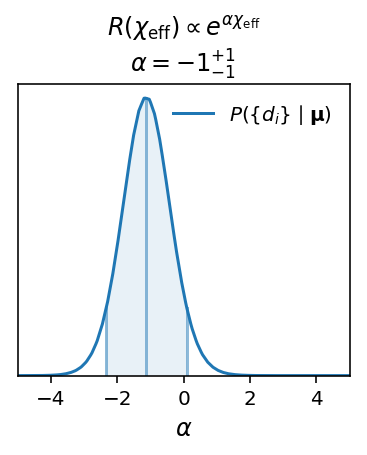

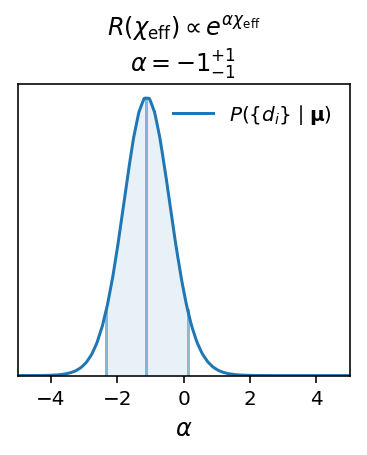

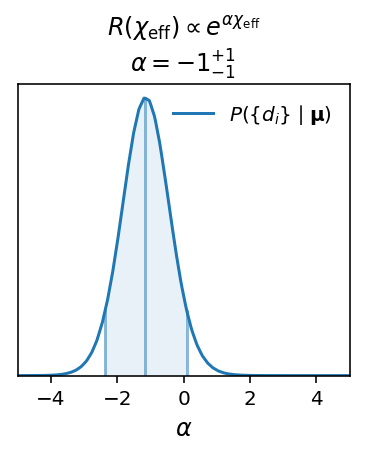

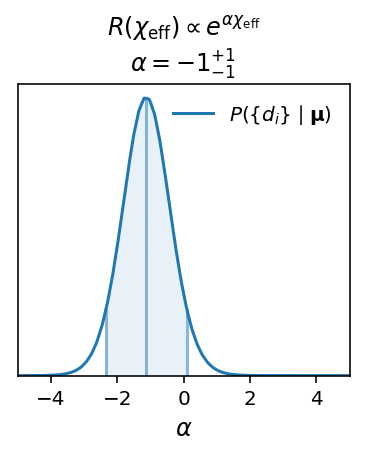

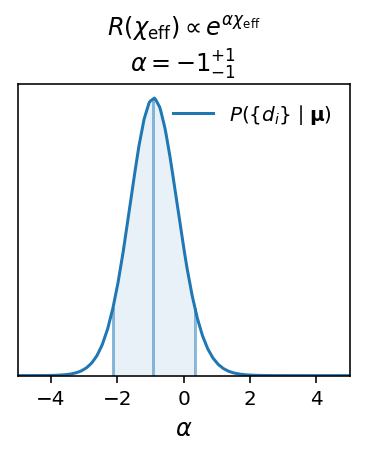

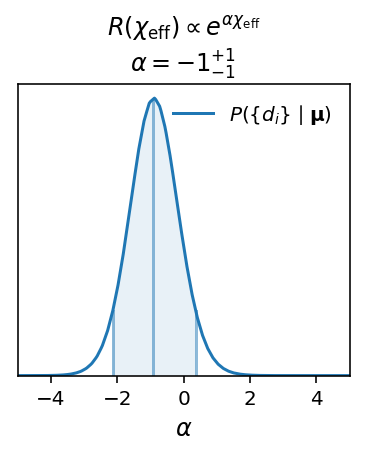

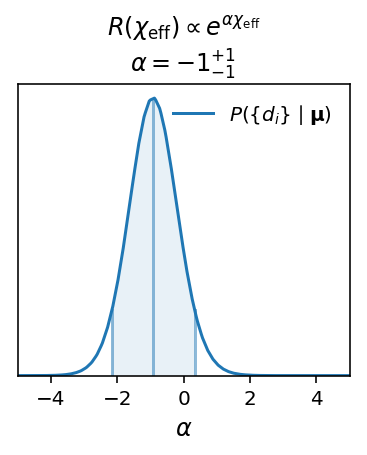

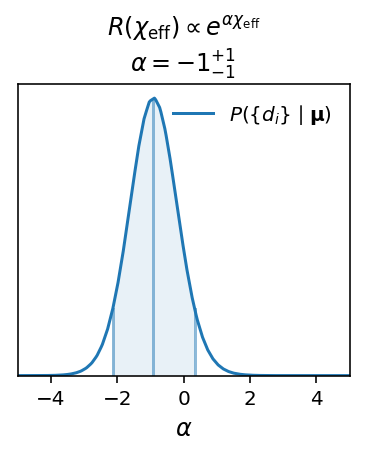

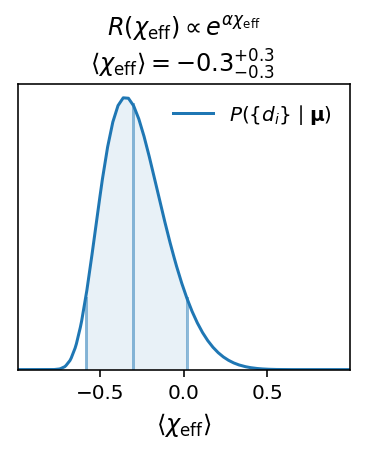

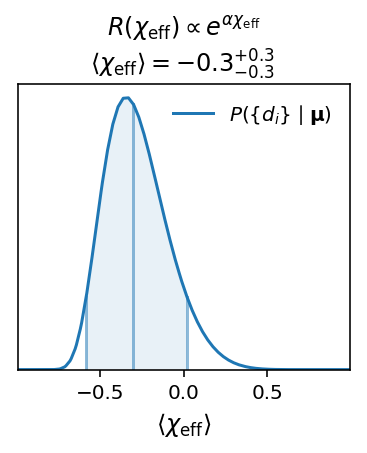

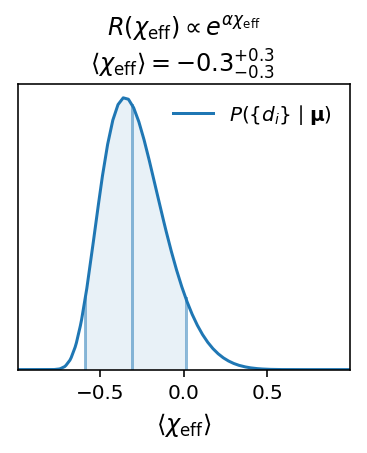

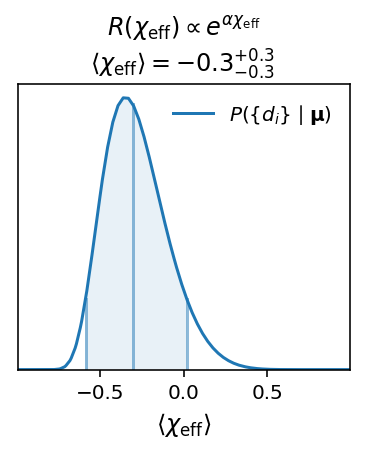

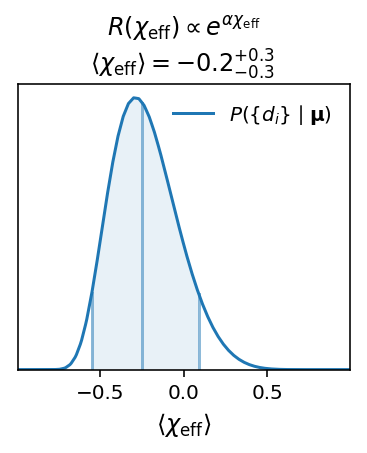

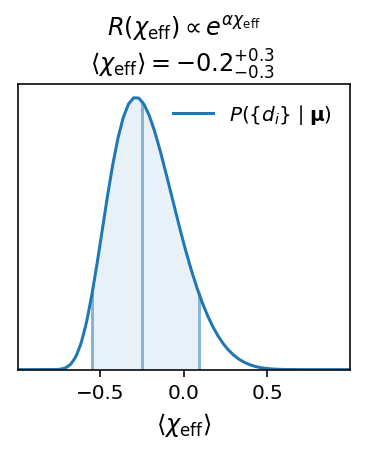

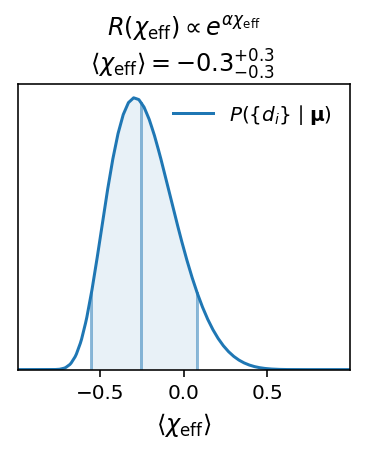

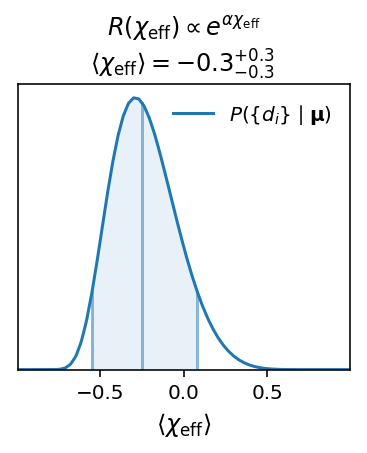

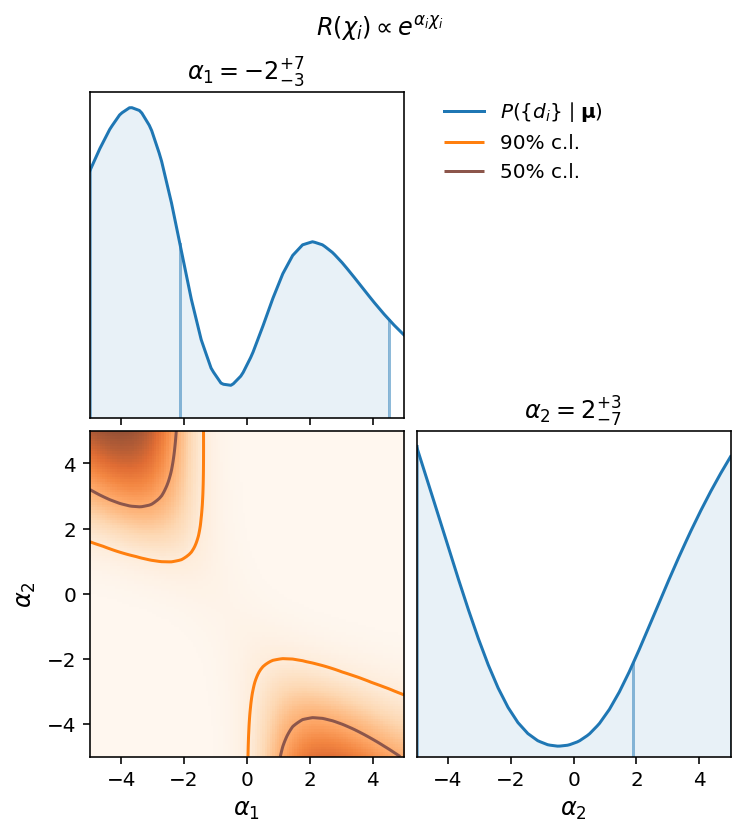

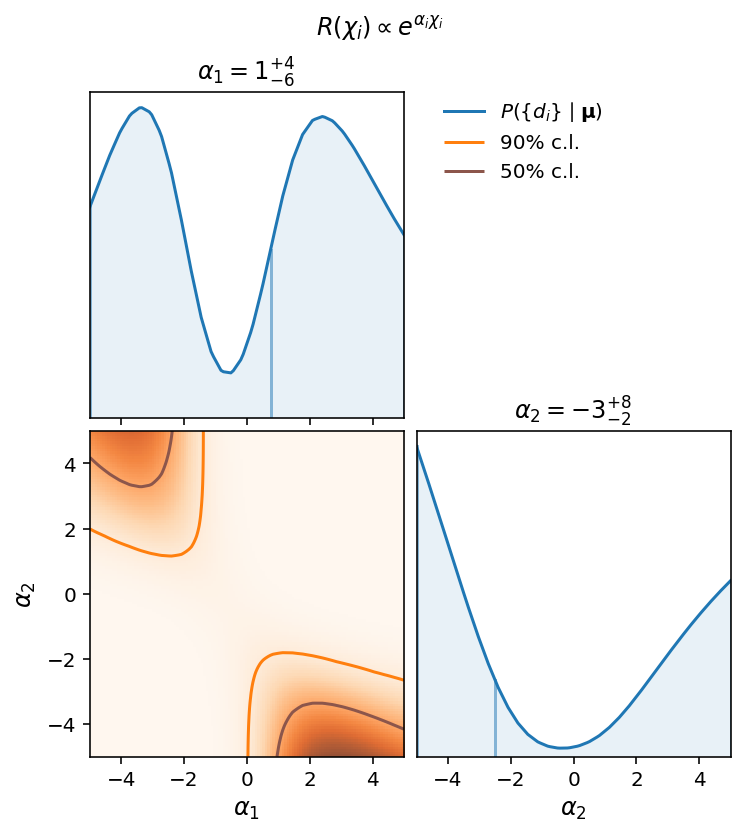

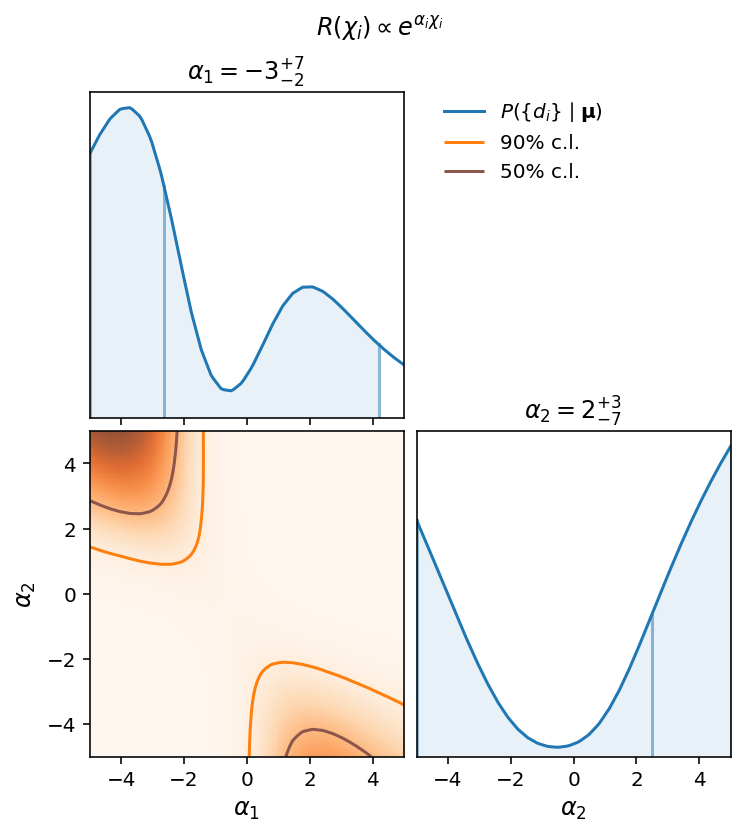

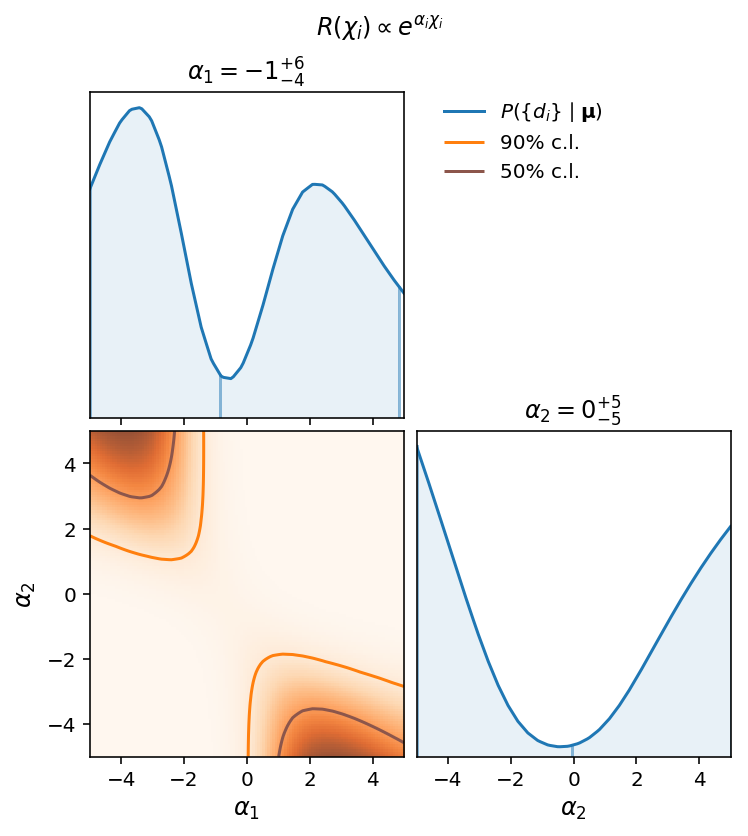

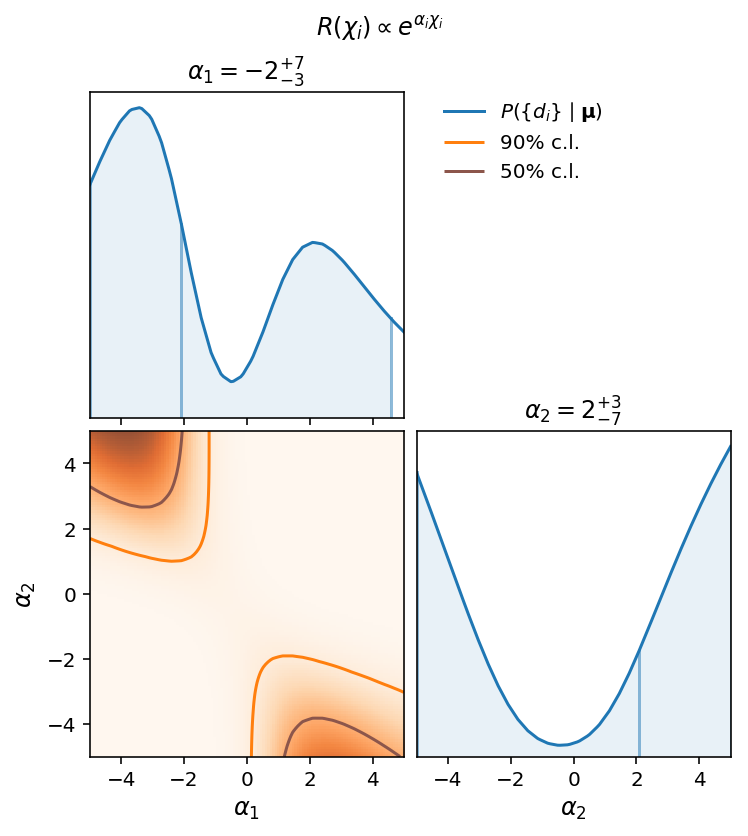

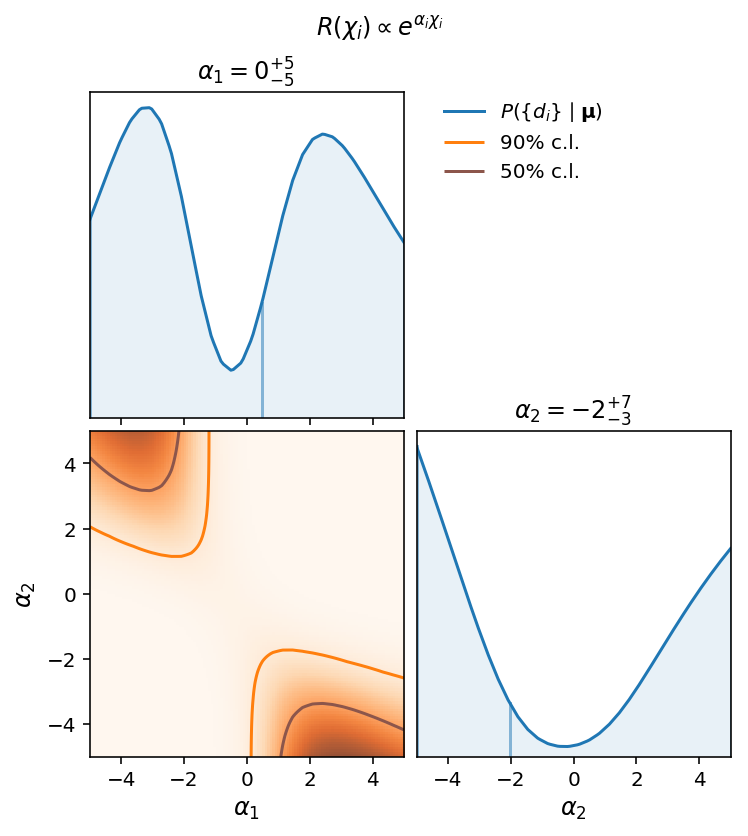

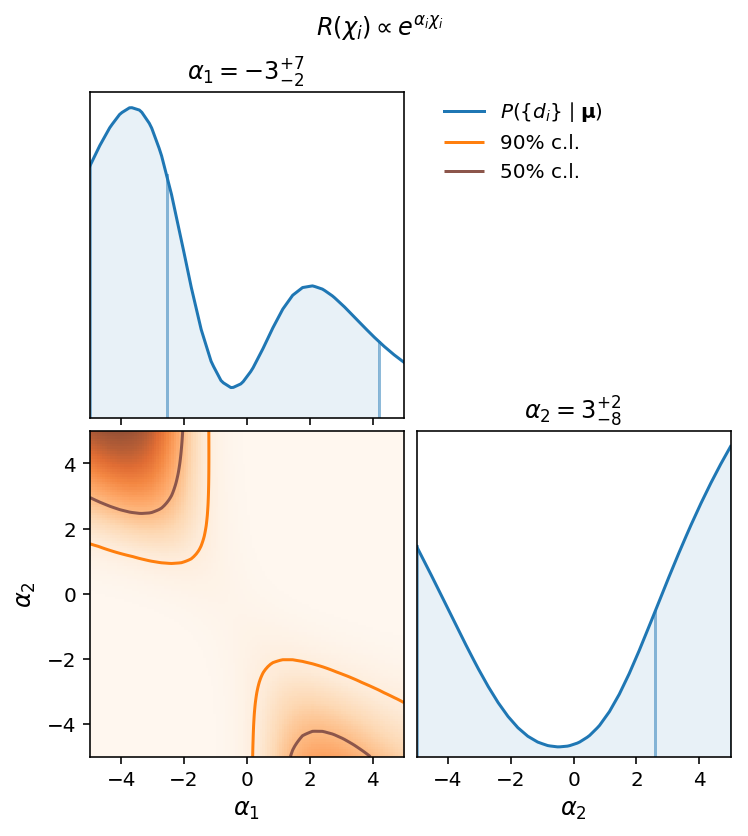

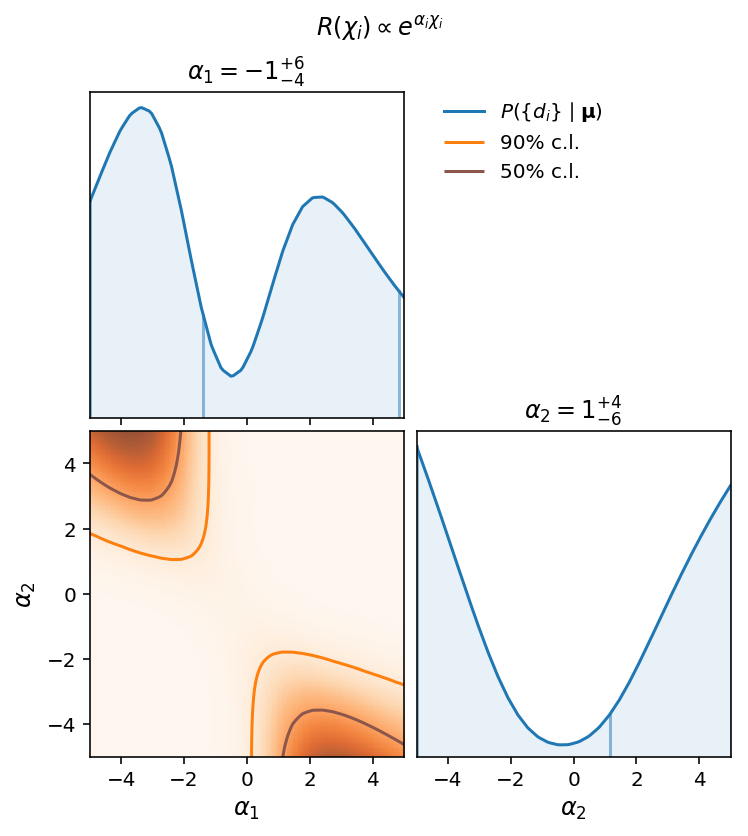

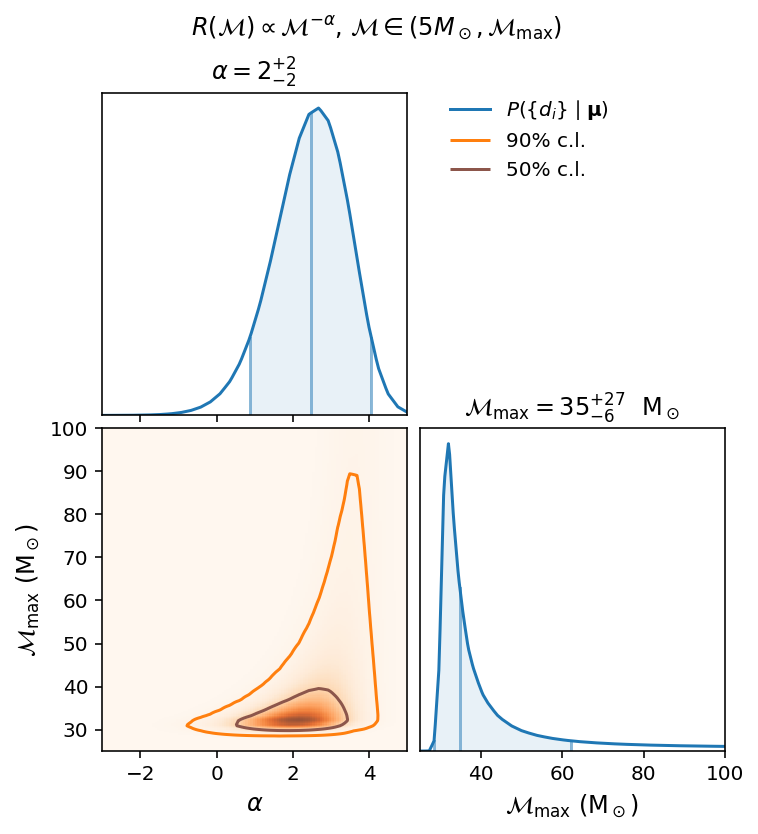

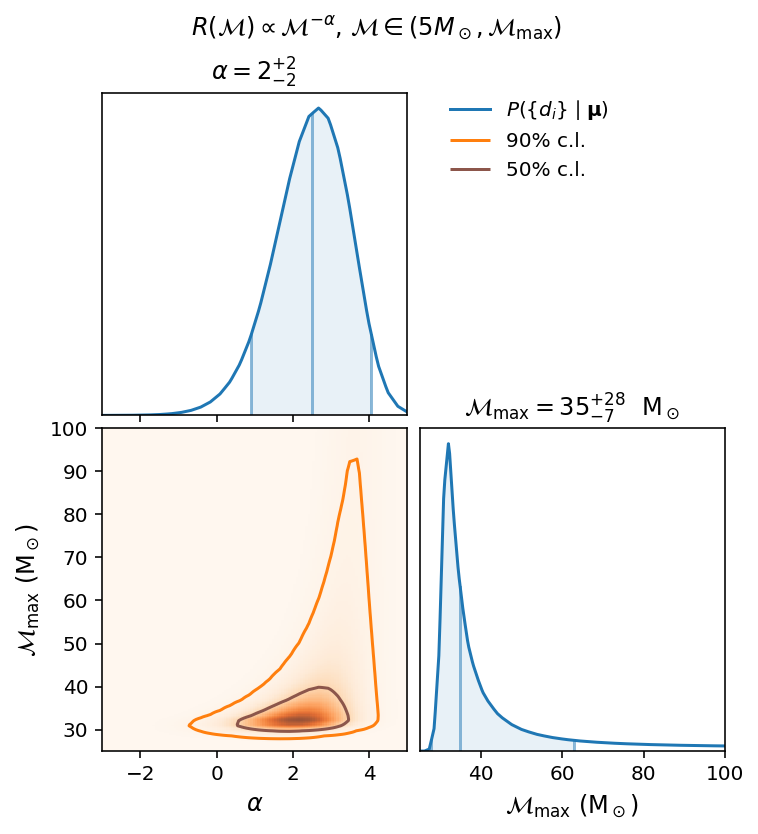

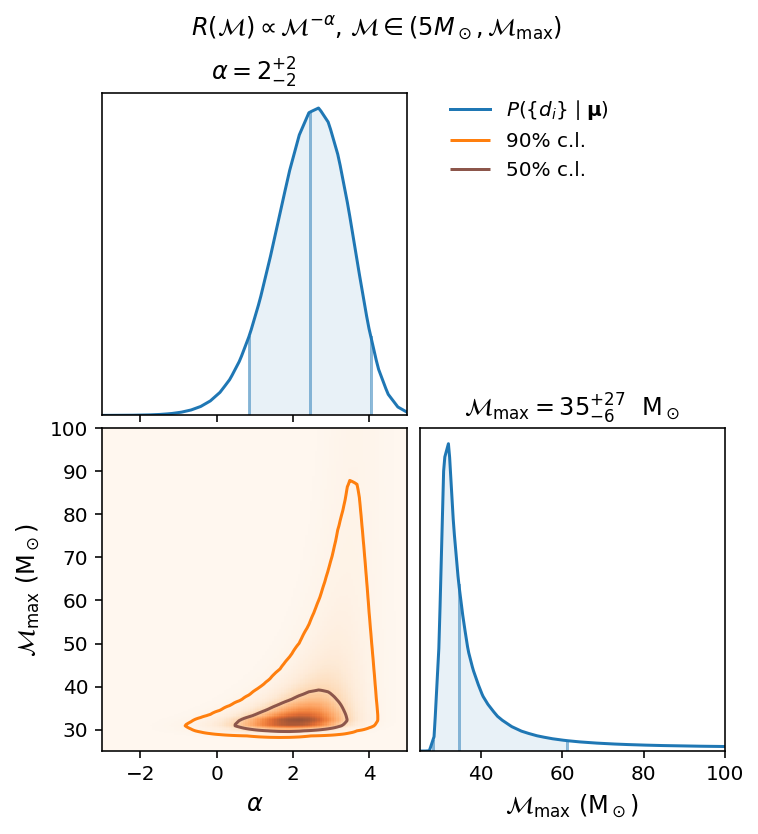

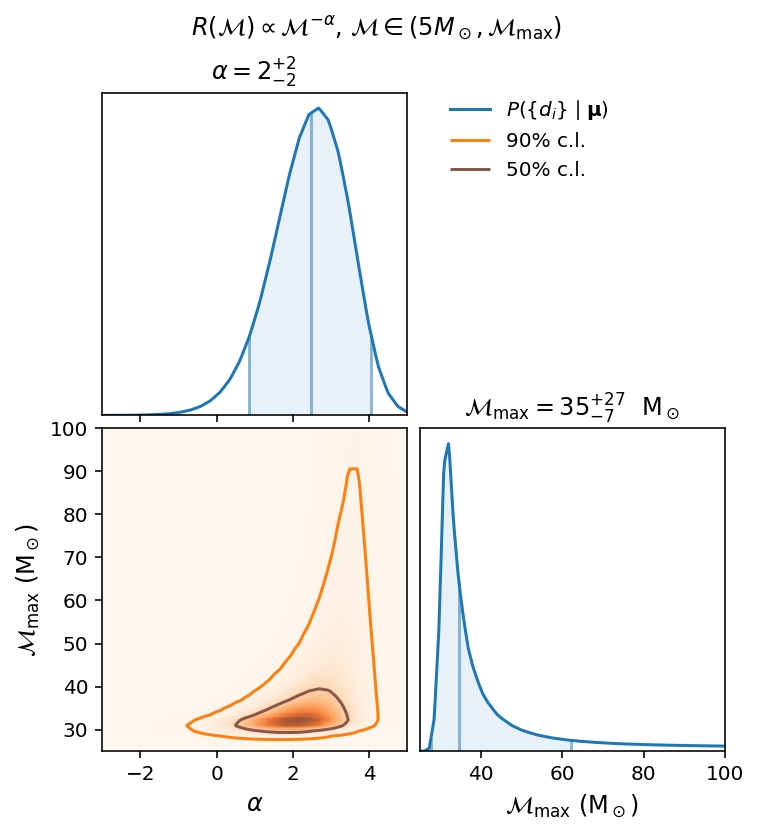

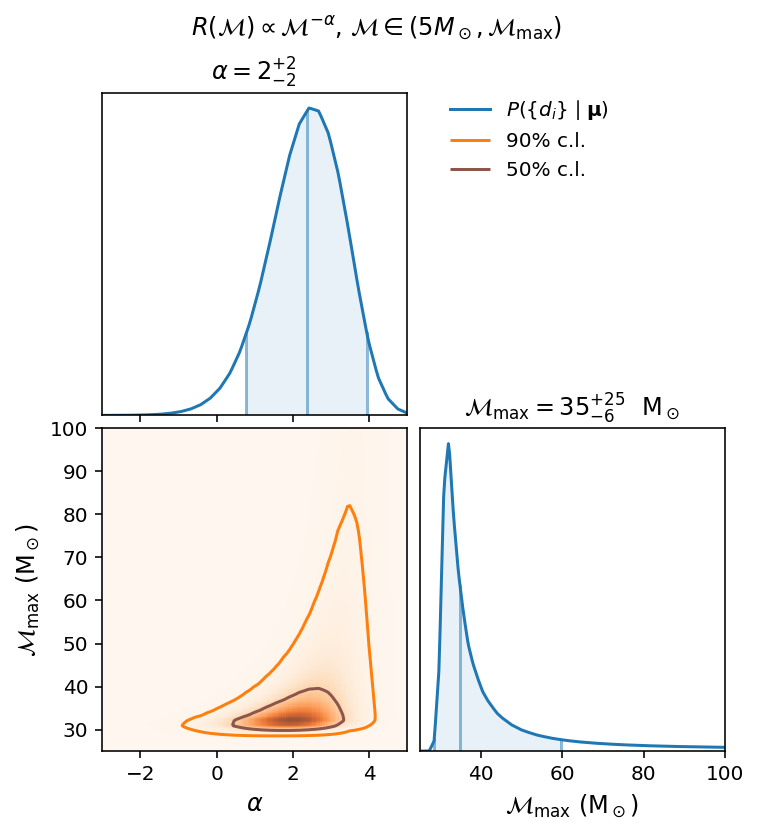

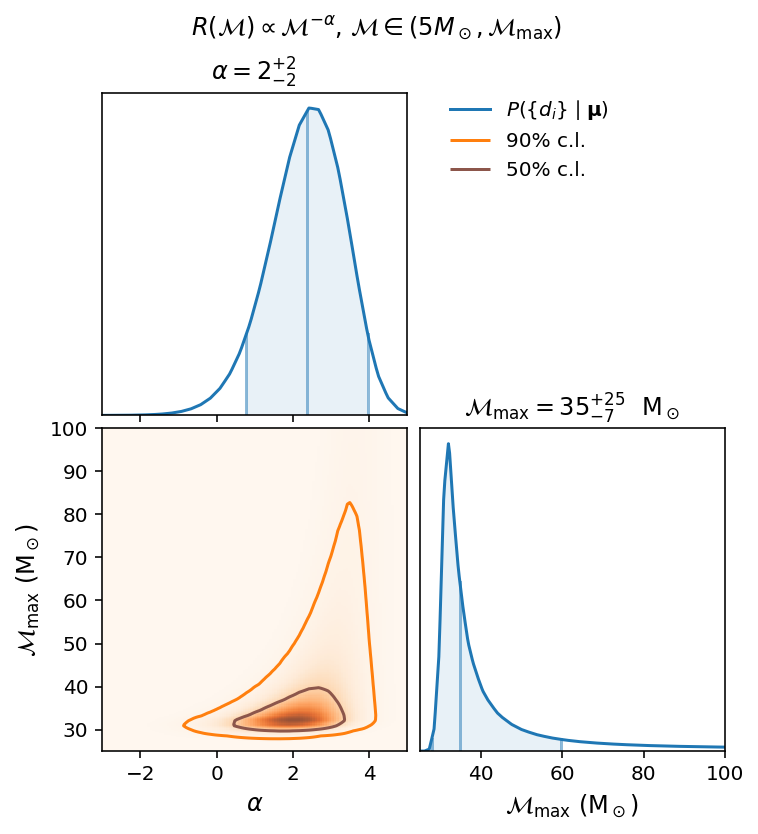

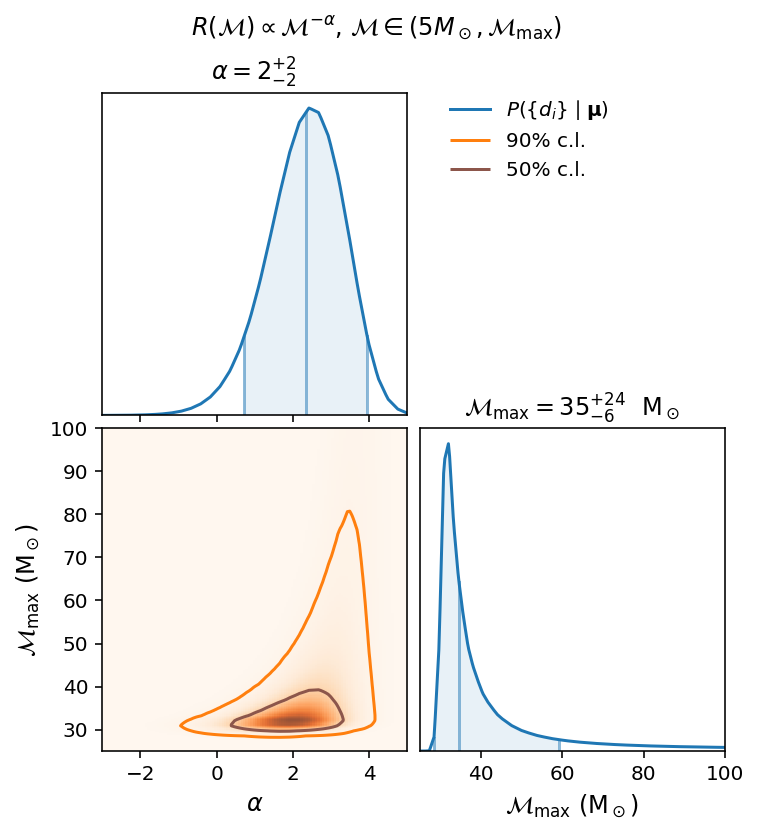

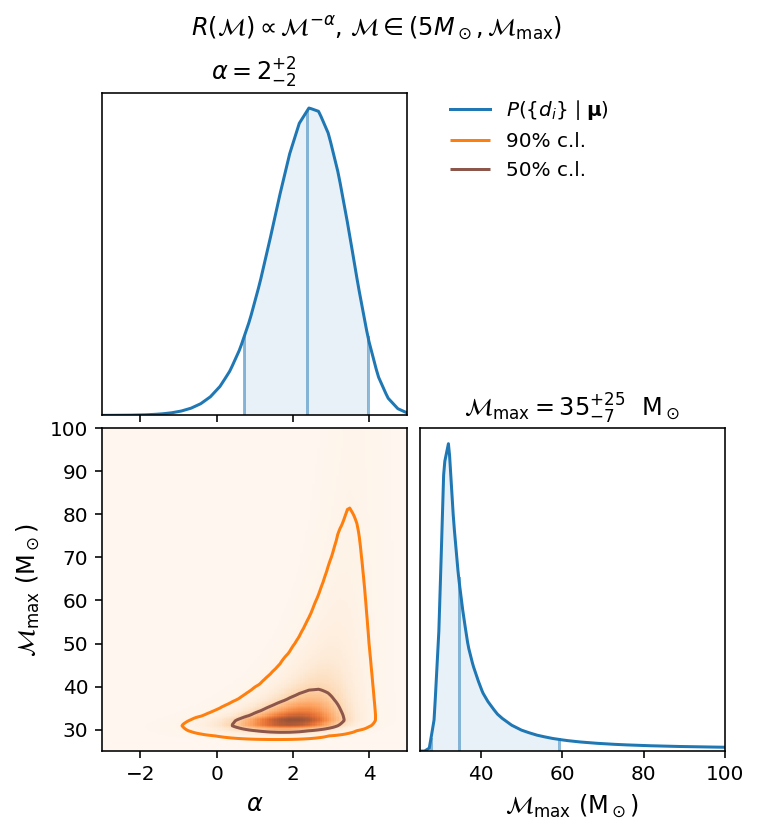

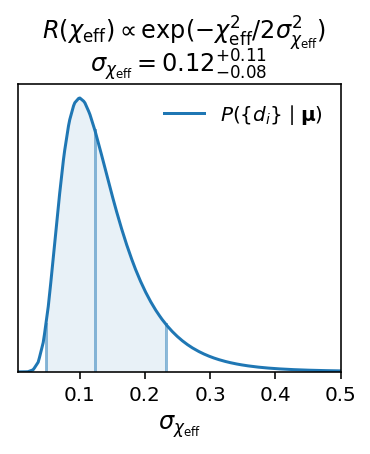

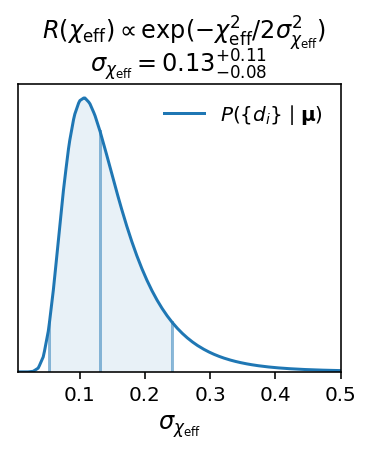

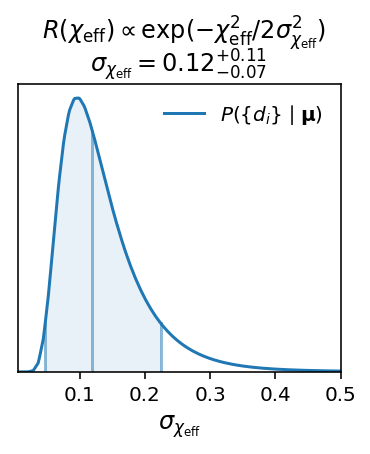

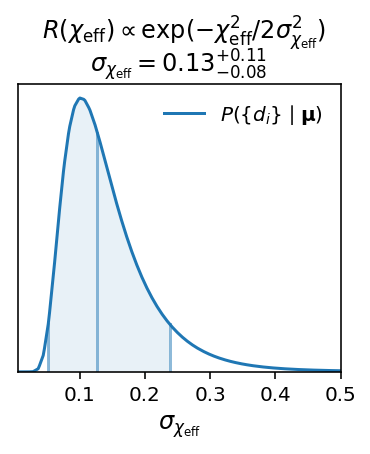

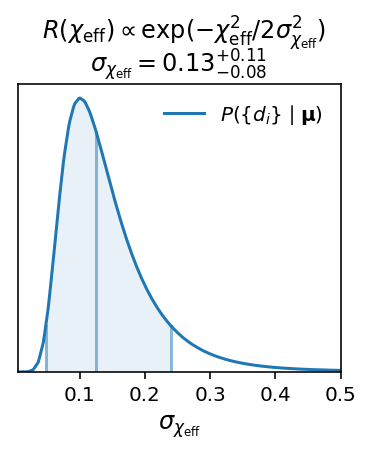

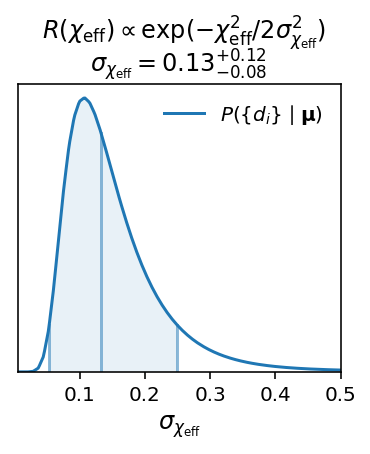

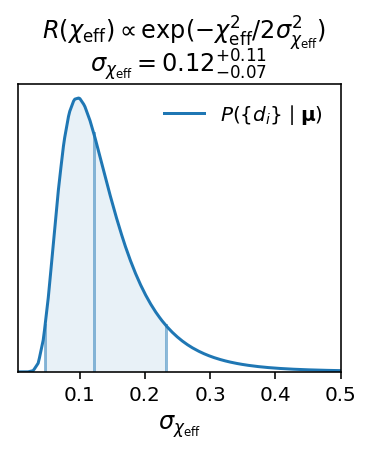

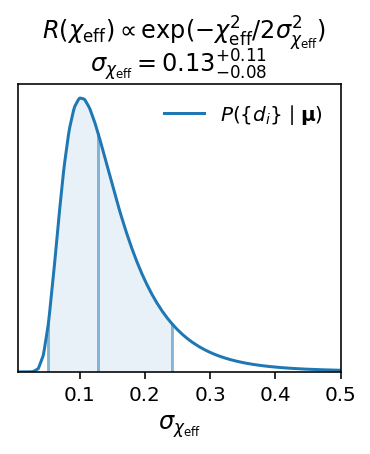

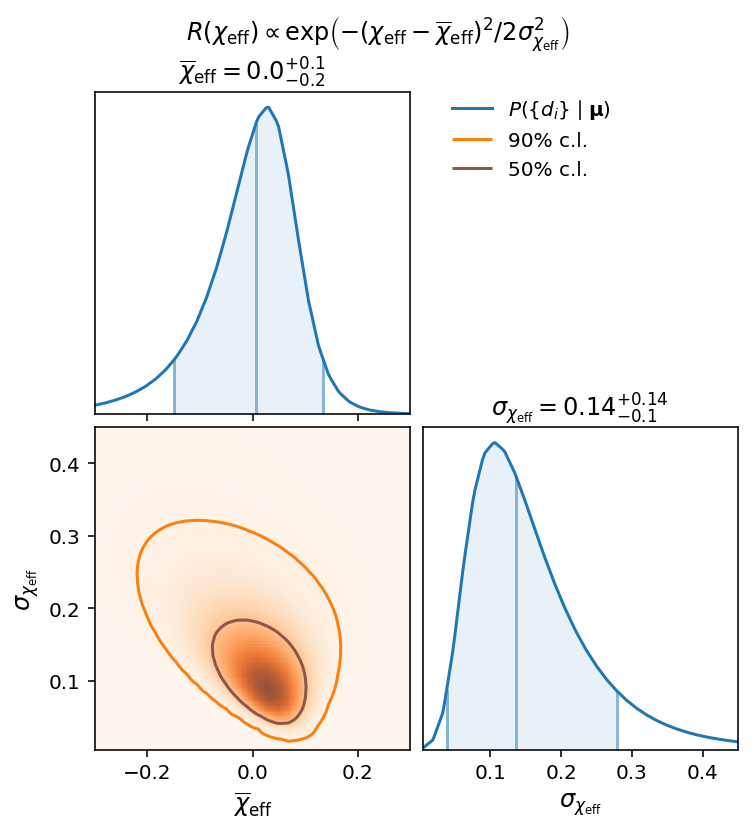

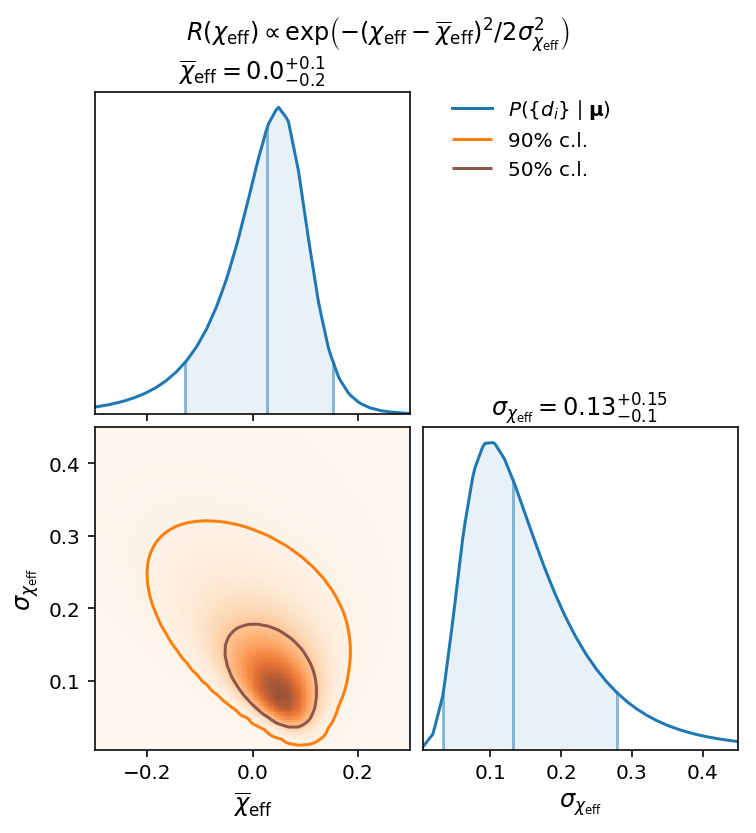

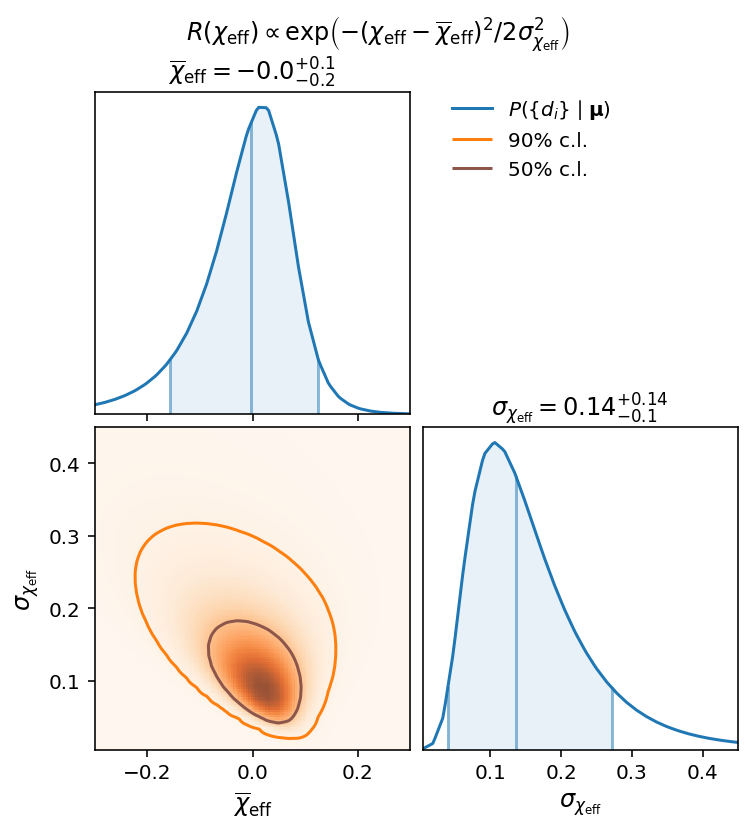

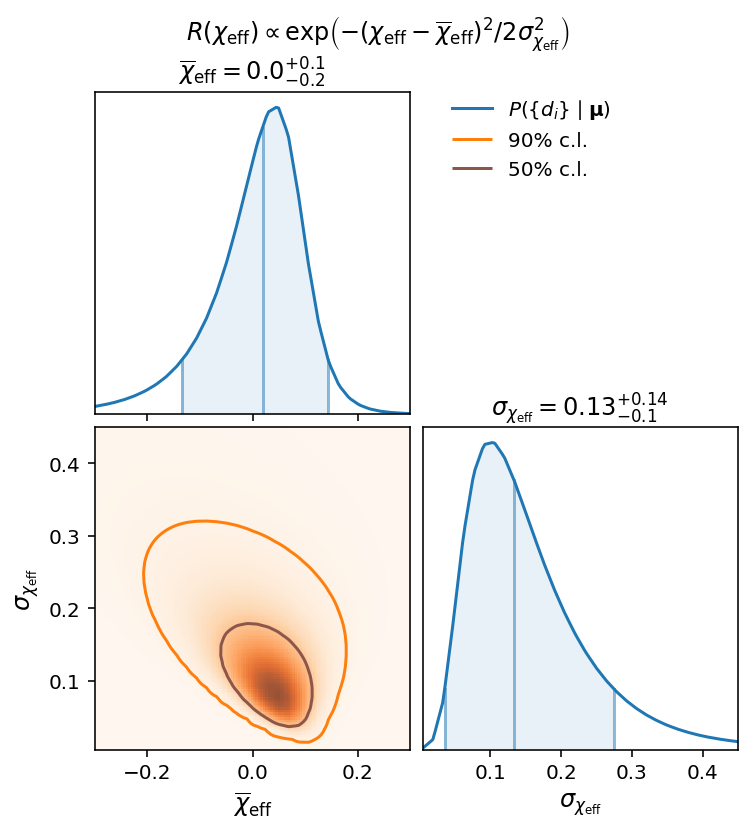

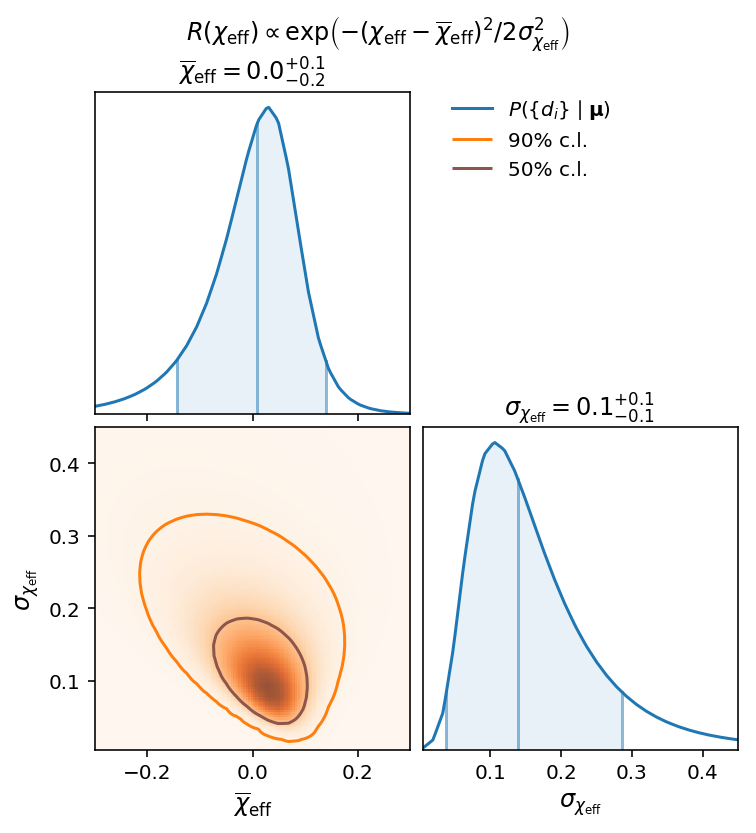

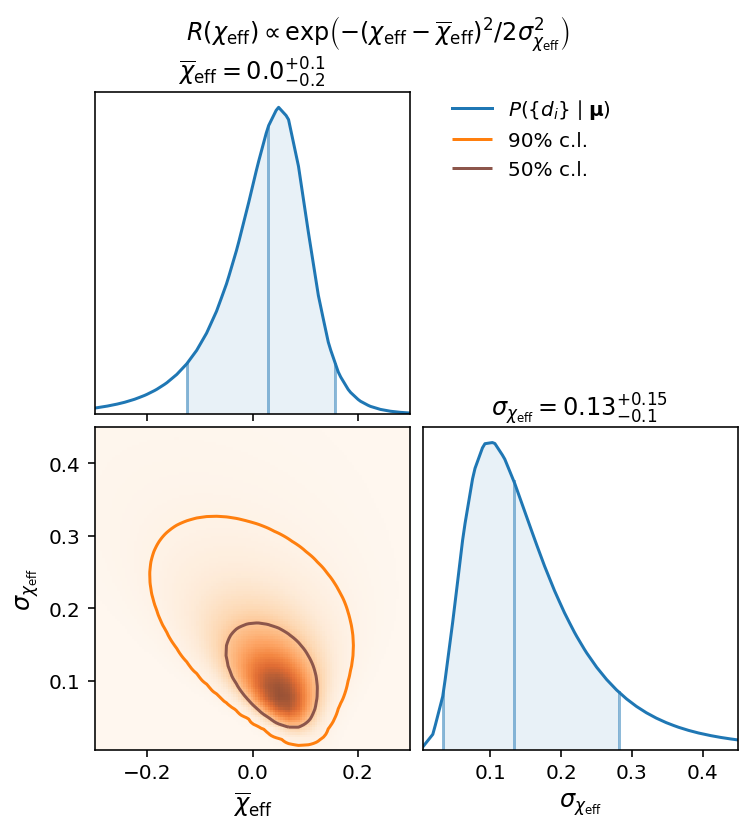

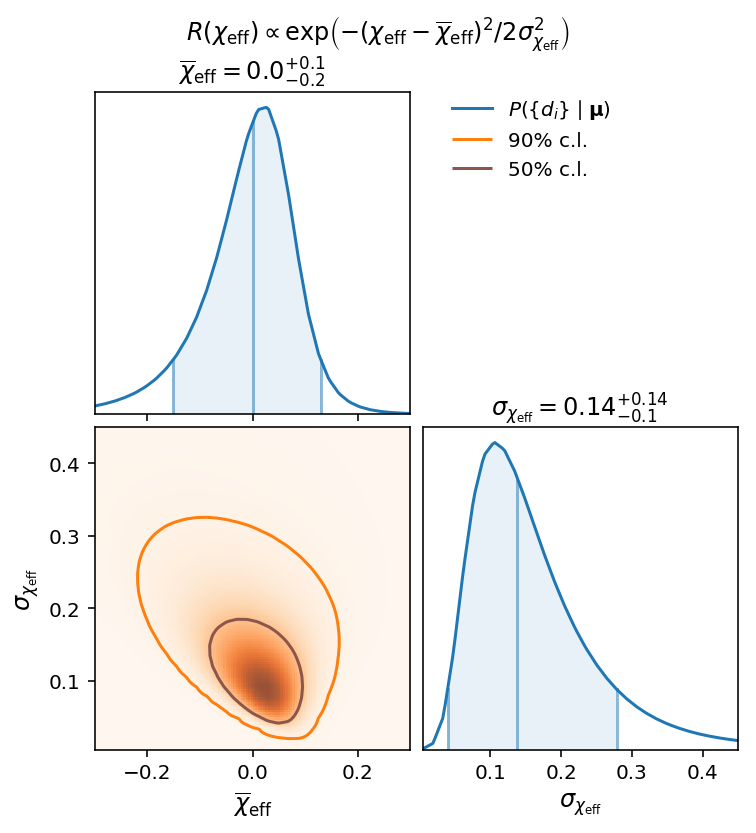

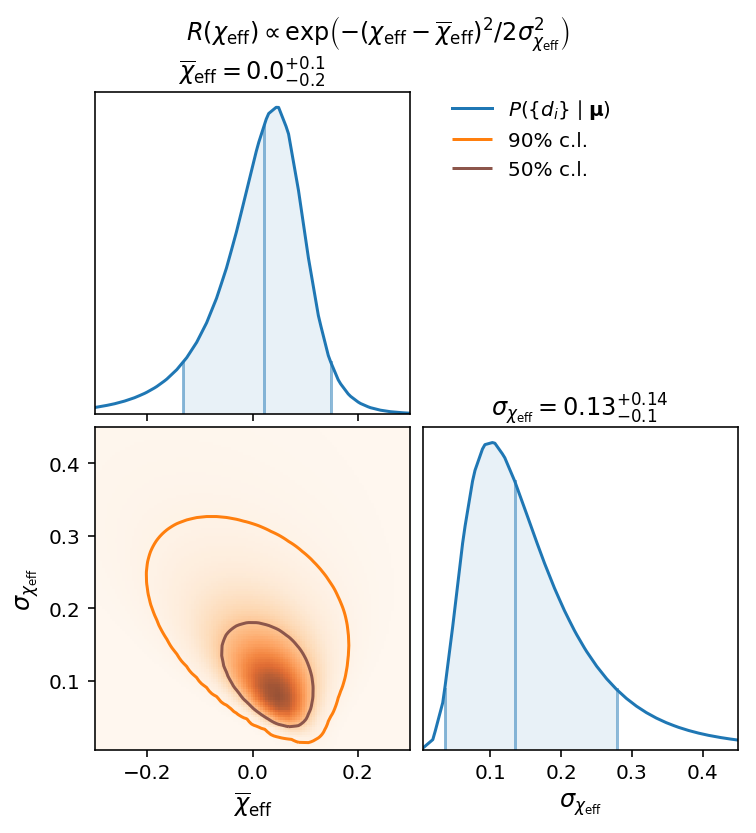

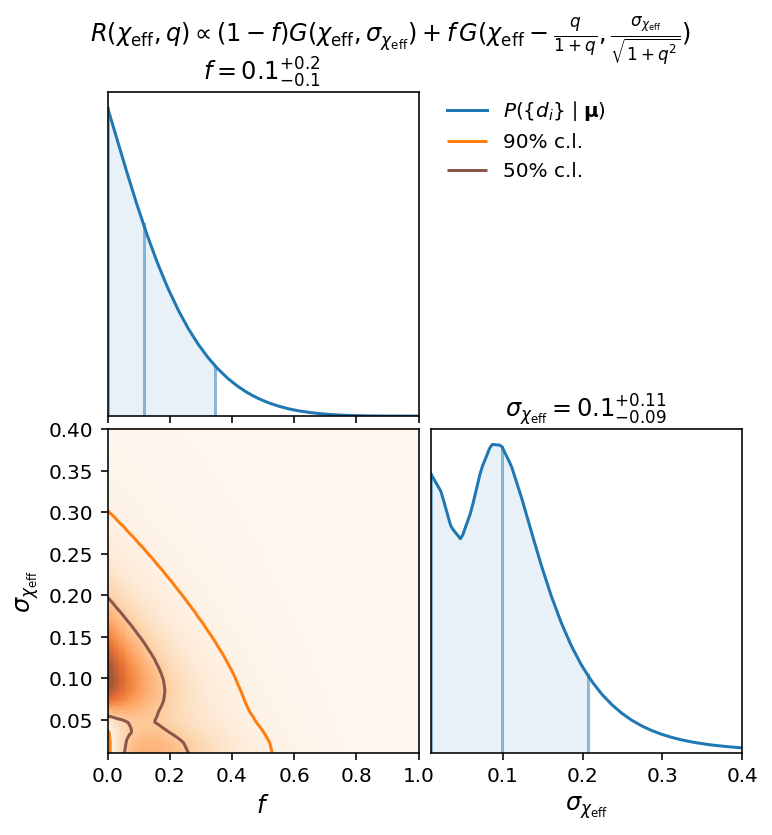

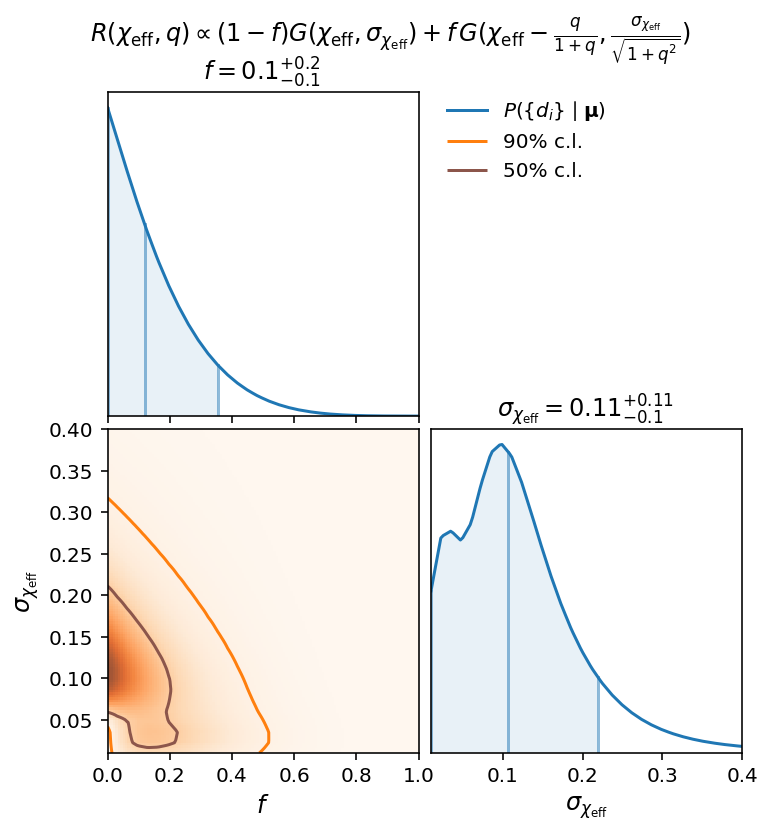

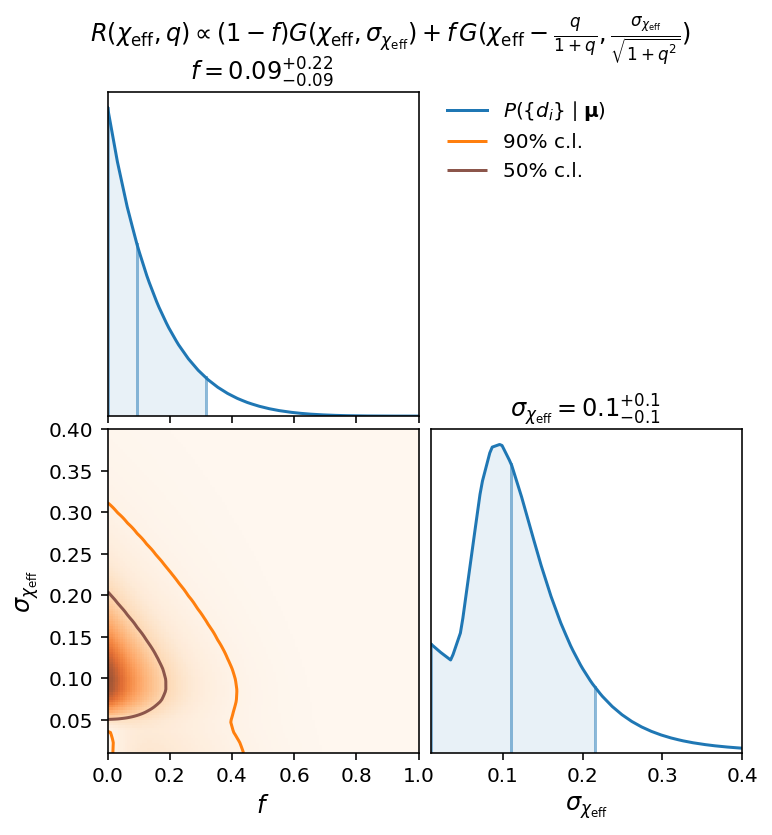

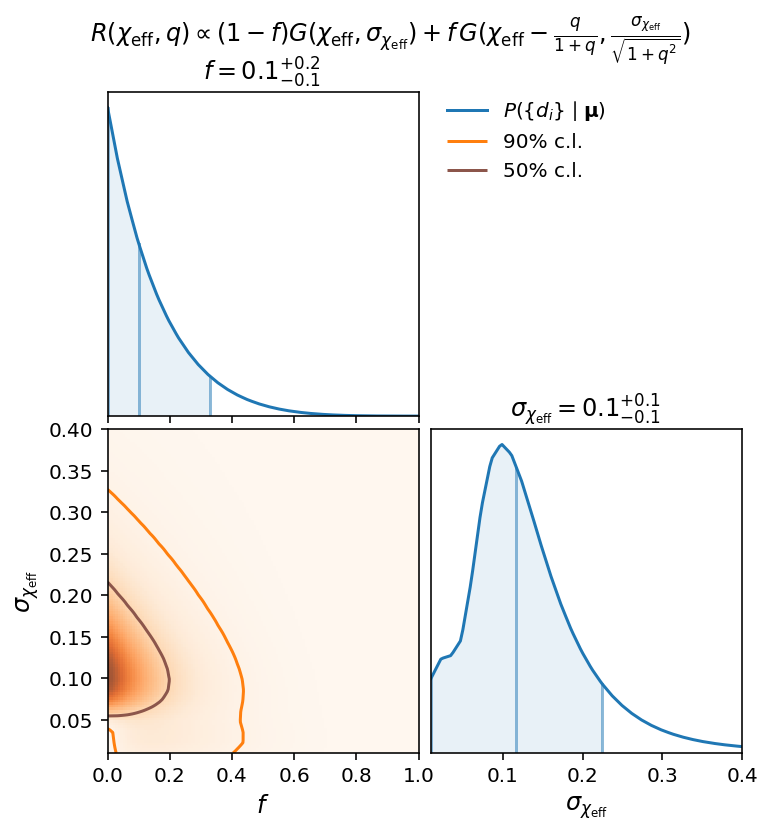

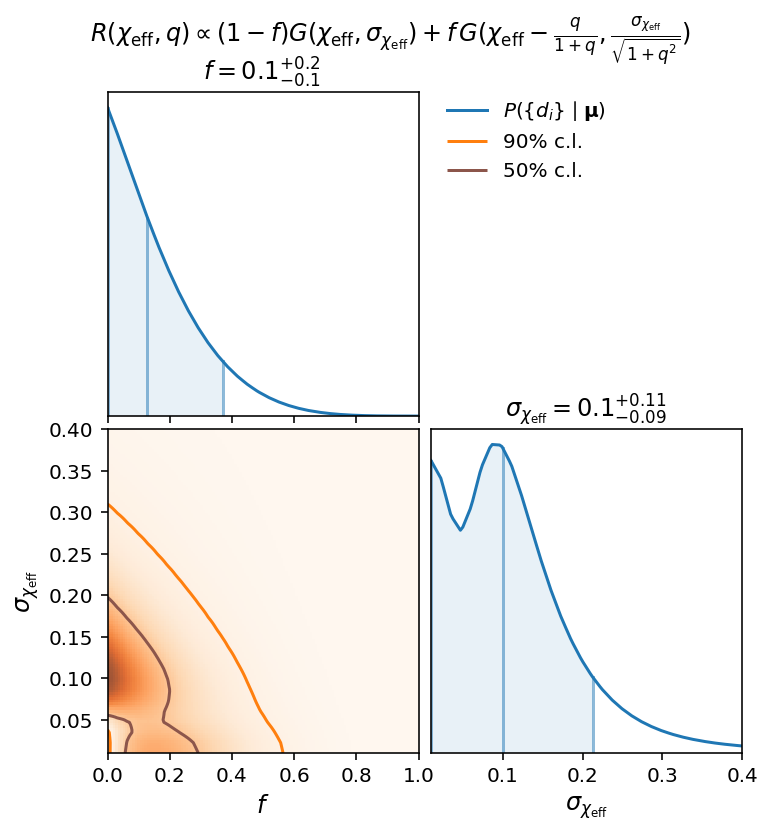

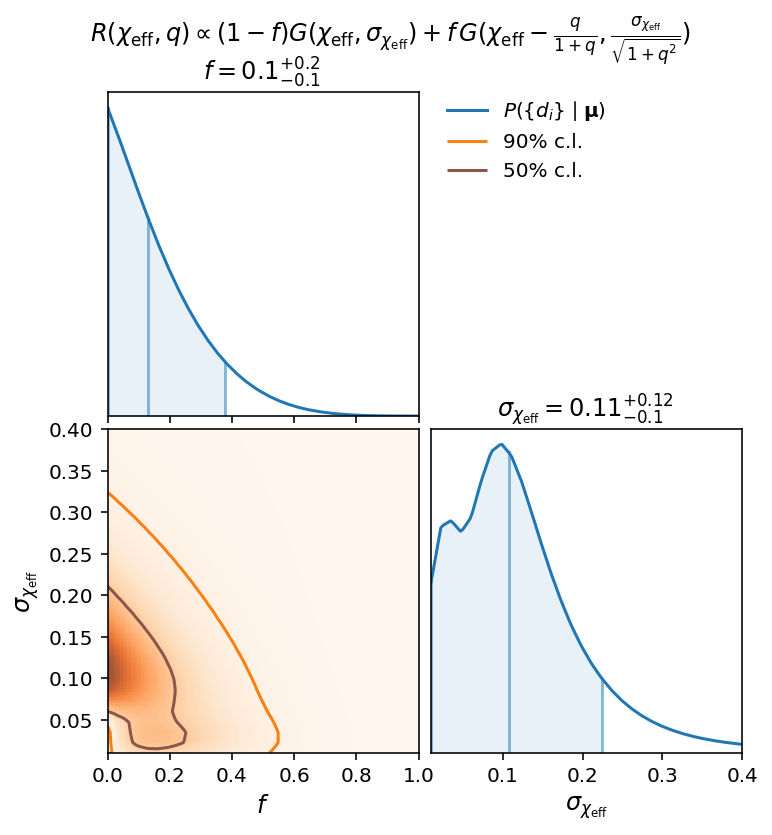

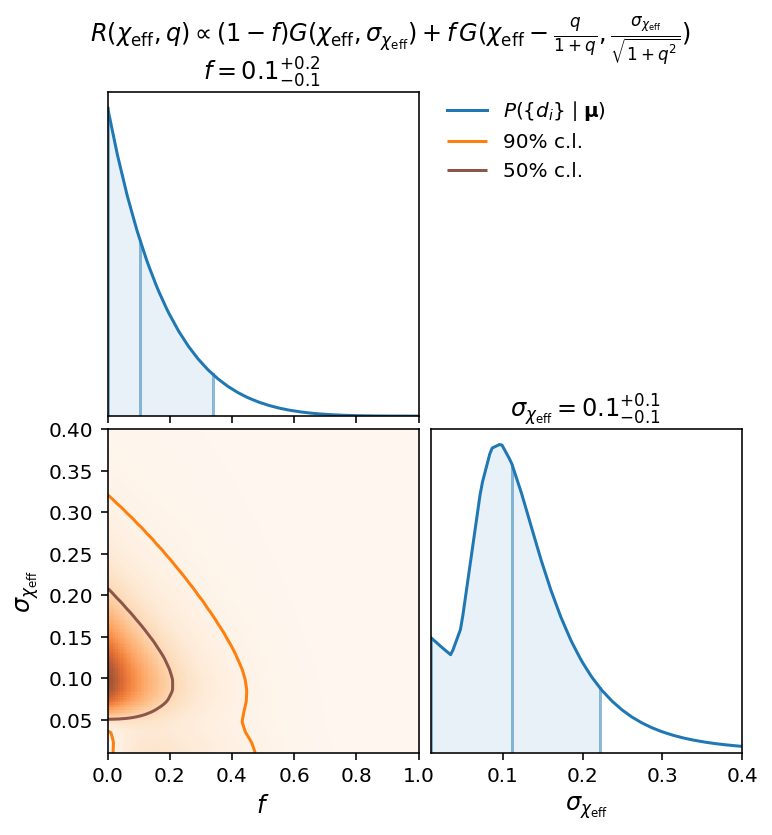

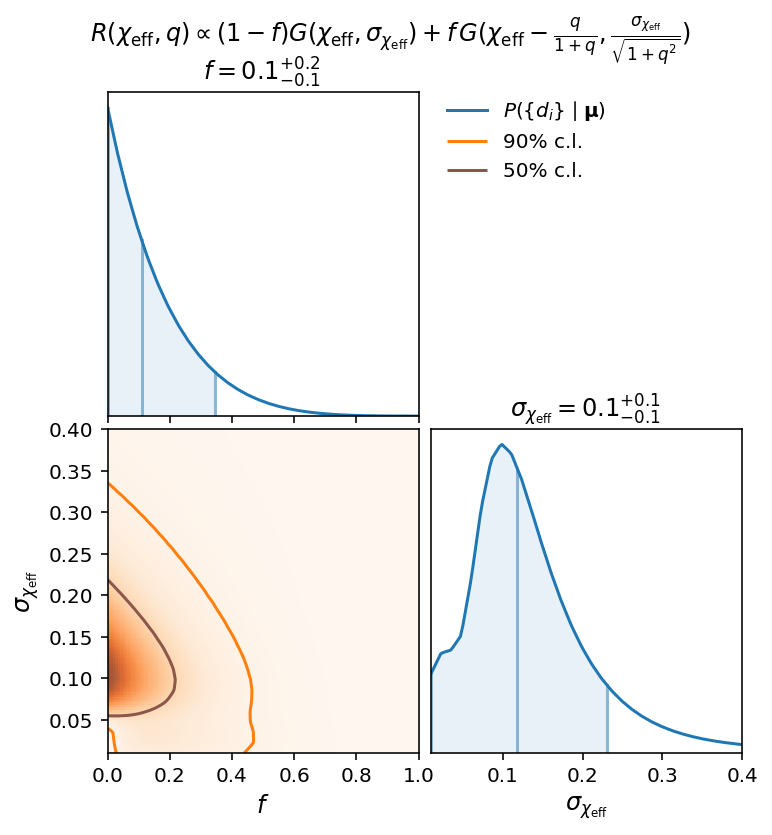

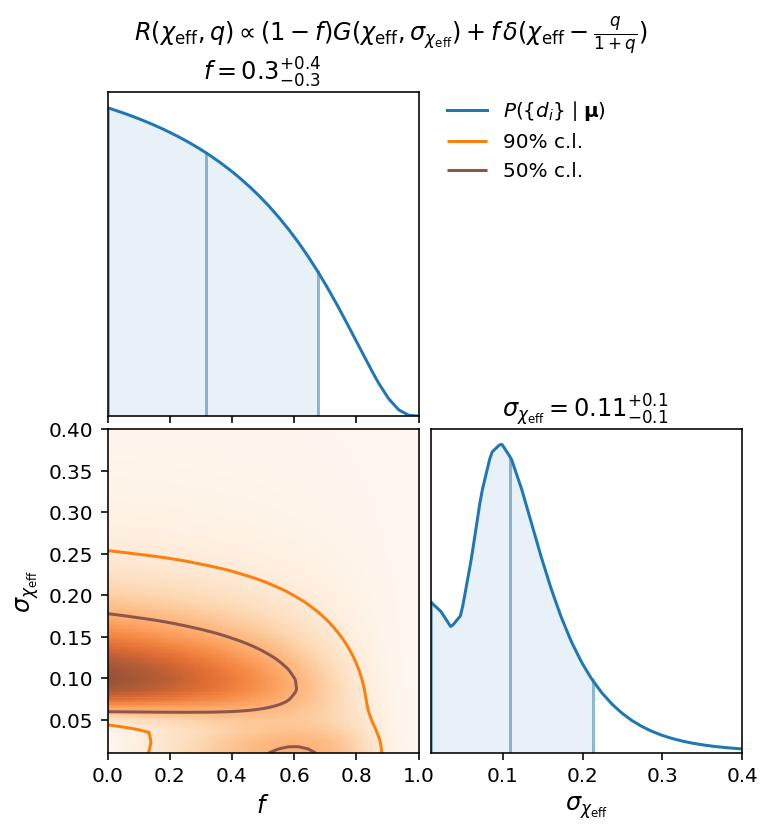

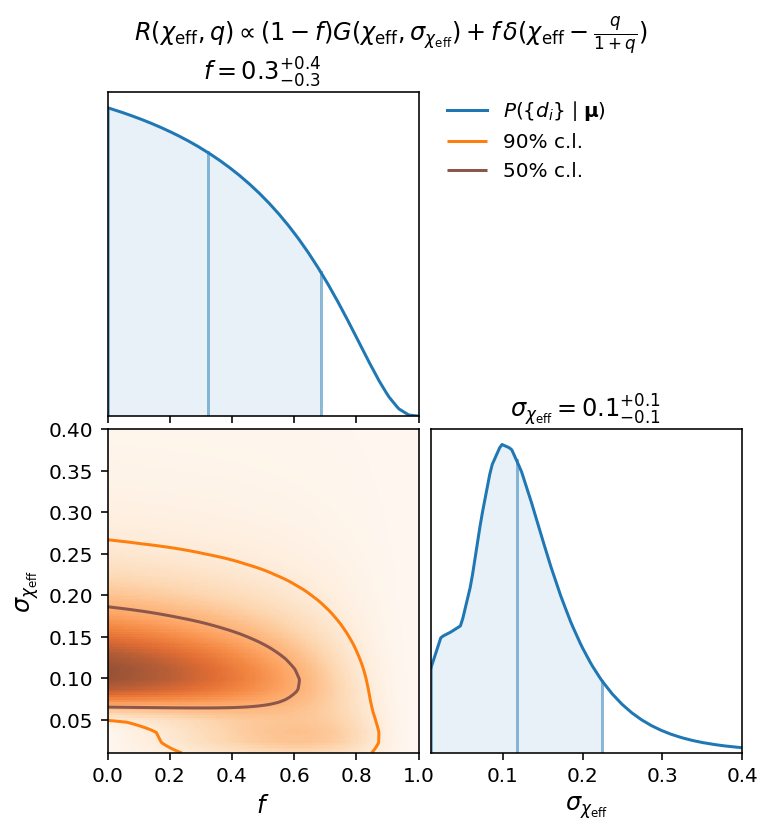

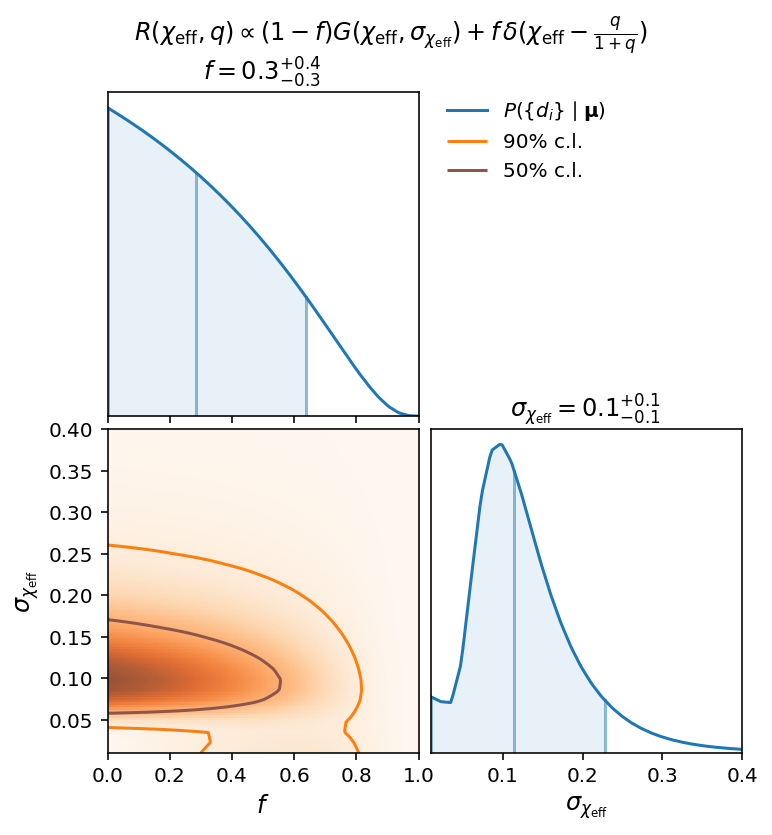

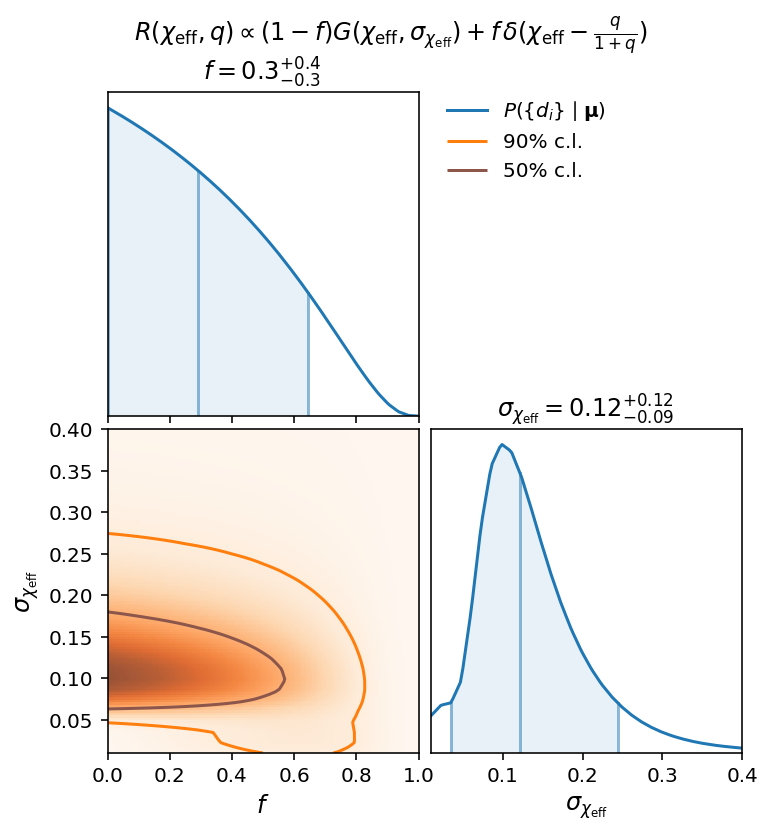

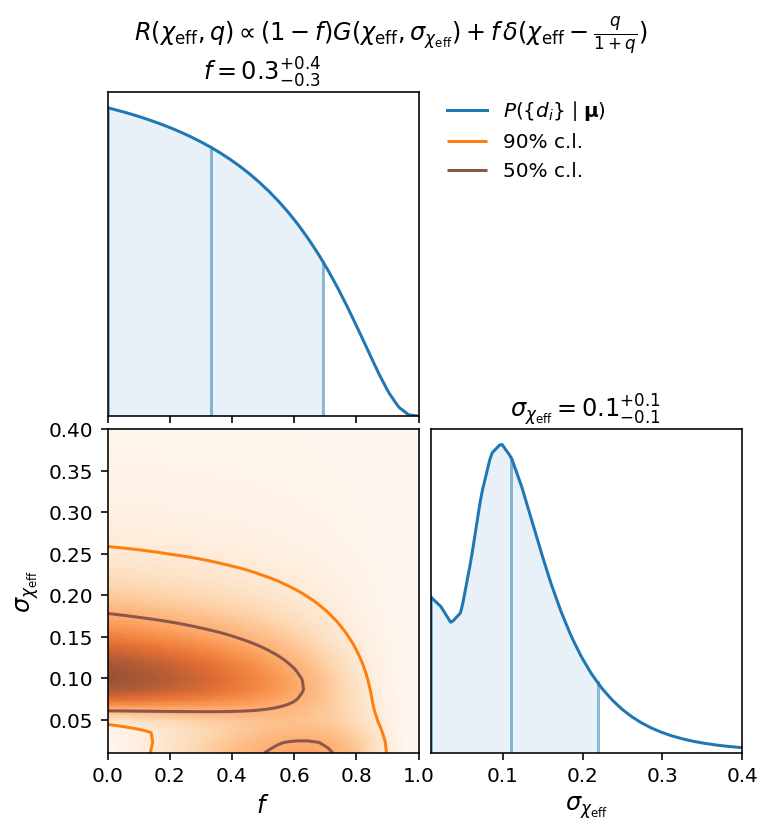

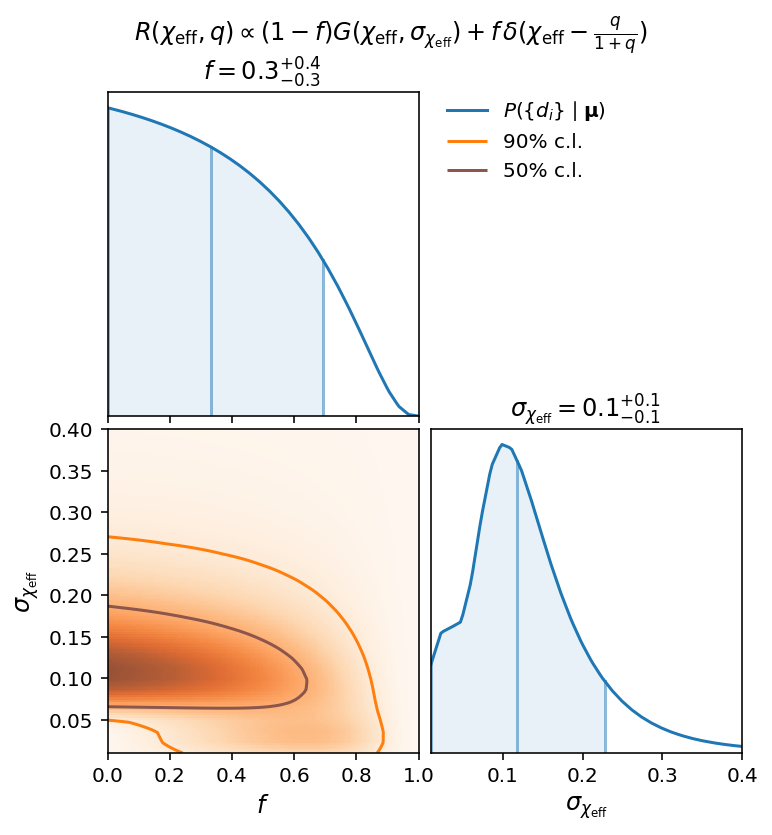

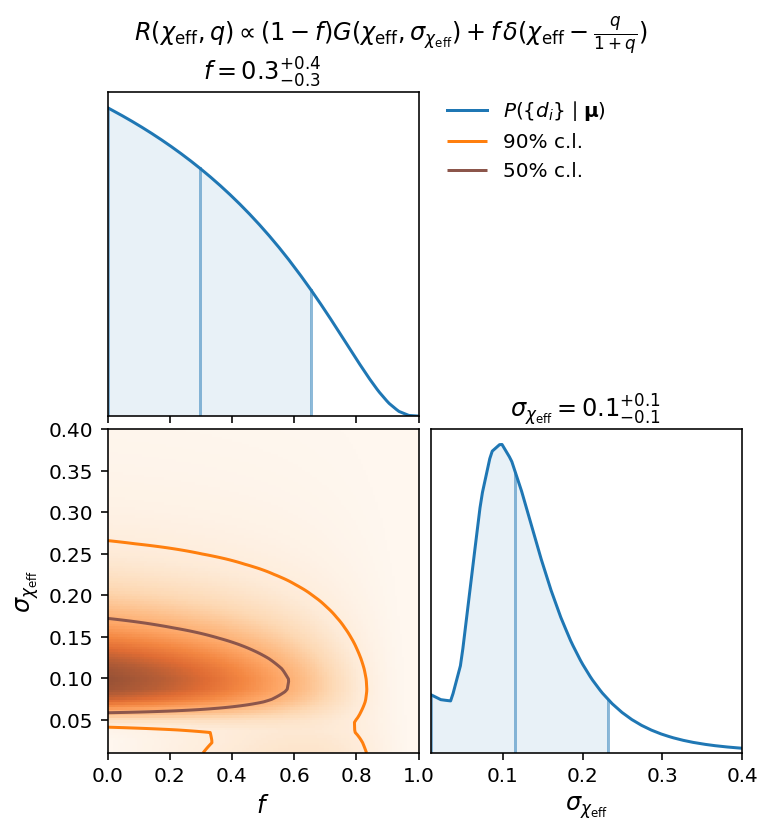

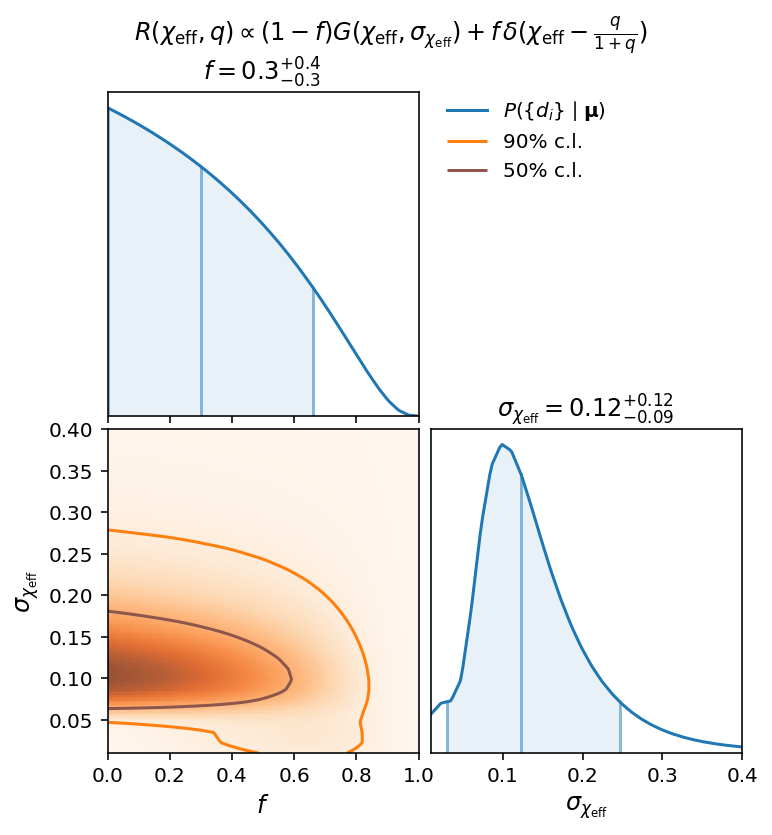

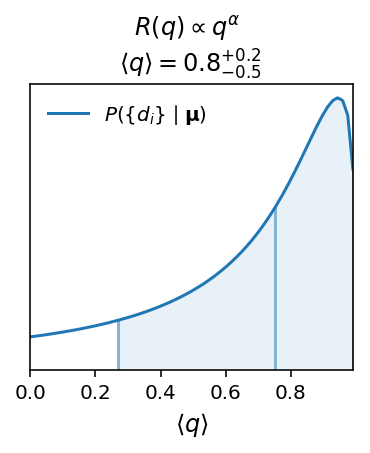

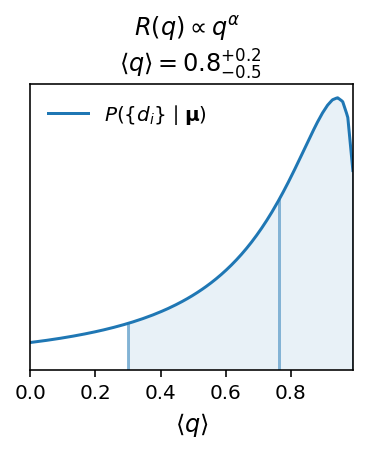

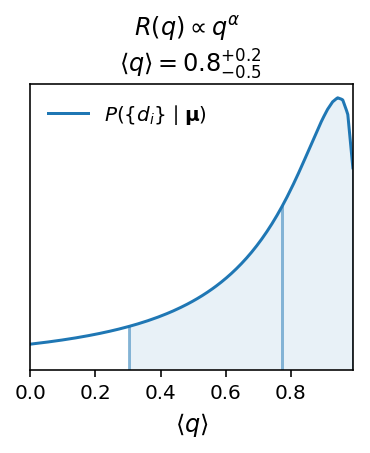

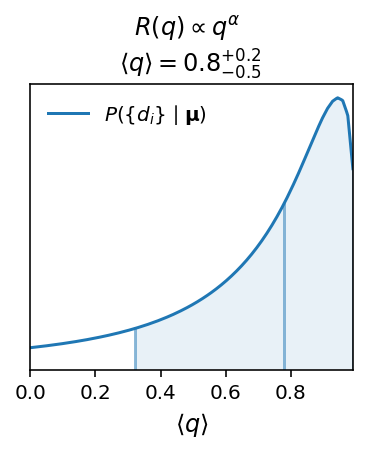

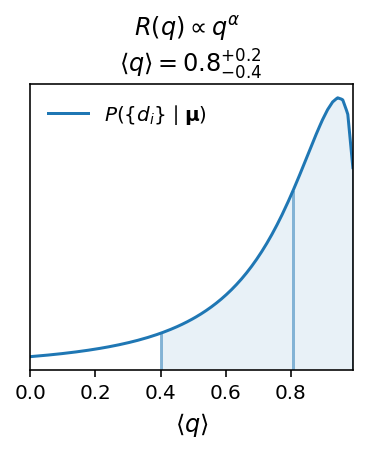

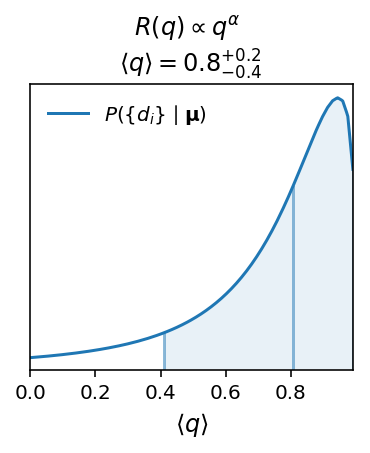

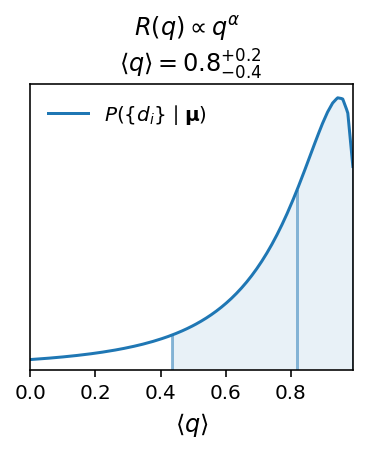

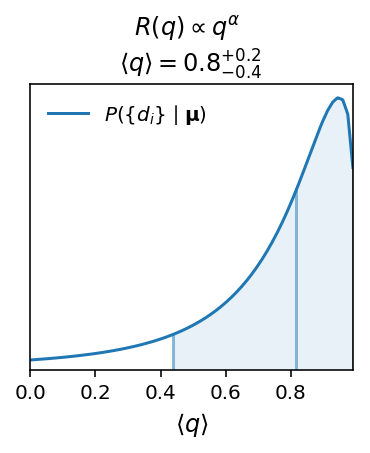

In [36]:
plt.clf();
for model in models:
    n_cols = n_rows = len(model.mu_params)
    for PCA in PSDs_coherences_approximants:
        fig, ax = plt.subplots(n_rows, n_cols, figsize=(2.7 * n_cols, 2.7 * n_rows + .5));
        if n_cols == 1: ax = [[ax]]
        plt.suptitle('{}'.format(model.latex), size='large')

        # Plot 2D likelihoods (off-diagonal in the plot grid)
        for row, y_par in list(enumerate(model.mu_params))[1:]:
            for col, x_par in list(enumerate(model.mu_params))[:row]:
                plt.sca(ax[row][col])
                xy_P = mu_igrid_2d[model.name, (x_par, y_par)]['P', (*PCA)].T

                plt.imshow(xy_P, extent=[*model.mu_bounds[x_par], *model.mu_bounds[y_par]],
                           cmap='Oranges', origin='lower', aspect='auto', alpha=.8)

                contours = plt.contour(mu_igrid_1d[model.name, x_par],
                                       mu_igrid_1d[model.name, y_par],
                                       xy_P,
                                       levels=levels[model.name, (*PCA), (x_par, y_par)],
                                       colors=['tab:orange', 'tab:brown'])
                for i in range(len(fractions)):
                    contours.collections[i].set_label('{:.0f}% c.l.'.format(100*fractions[i]))

        # Plot 1D likelihoods (diagonal)
        for i, mu_par in enumerate(model.mu_params):
            plt.sca(ax[i][i])
            for val in [median[model.name, (*PCA), mu_par], *bounds_estimate[model.name, (*PCA), mu_par]]:
                plt.plot([val]*2, [0, np.interp(val, mu_igrid_1d[model.name, mu_par],
                                                mu_igrid_1d[model.name, 'P', mu_par, (*PCA)])],
                          'C0', alpha=.5)
            span = np.linspace(*bounds_estimate[model.name, (*PCA), mu_par])
            plt.fill_between(span, 0, np.interp(span, mu_igrid_1d[model.name, mu_par],
                                                mu_igrid_1d[model.name, 'P', mu_par, (*PCA)]), alpha=.1)
            
            plt.title('{}$=${} {}'.format(
                latex[mu_par],
                latex_val_err(median[model.name, (*PCA), mu_par],
                              err_estimate[model.name, (*PCA), mu_par]),
                unit[mu_par].replace('(', '').replace(')','')))

            plt.plot(mu_igrid_1d[model.name, mu_par],
                     mu_igrid_1d[model.name, 'P', mu_par, (*PCA)], 
                     label=r'$P(\{d_i\} \mid \mathbf{\mu})$')

        # Embellish
        for col, x_par in enumerate(model.mu_params):
            ax[n_rows-1][col].set_xlabel(latex[x_par] + unit[x_par], size='large')
            for row in range(n_rows-1):
                ax[row][col].tick_params(labelbottom='off')
        for row, y_par in list(enumerate(model.mu_params))[1:]:
            ax[row][0].set_ylabel(latex[y_par] + unit[y_par], size='large')
            for col in range(1, n_cols):
                ax[row][col].tick_params(labelleft='off')
        for row in range(n_rows-1):
            for col in range(row+1, n_cols):
                ax[row][col].axis('off')
        for col in range(n_cols):
            for row in range(1, n_rows):
                ax[0][col].get_shared_x_axes().join(ax[0][col], ax[row][col])
                ax[row][col].autoscale()
        for row in range(n_rows):
            for col in range(1, row):
                ax[row][0].get_shared_y_axes().join(ax[row][0], ax[row][col])
                ax[row][col].autoscale()
        for i in range(len(model.mu_params)):
            ax[i][i].tick_params(axis='y', left='off', labelleft='off')
            ax[i][i].set_ylim(ymin=0)
        ax[-1][-1].set_xlim(model.mu_bounds[model.mu_params[-1]])
        plt.tight_layout(rect=[0, 0, 1, 0.96]);
        plt.subplots_adjust(hspace=0.04, wspace=0.04);

        handles_1d, labels_1d = ax[0][0].get_legend_handles_labels()
        try:
            handles_2d, labels_2d = ax[1][0].get_legend_handles_labels()
            pos = ax[0][1].get_position()
            fig.legend(handles_1d + handles_2d, labels_1d + labels_2d, 
                       loc='upper left', bbox_to_anchor=(pos.x0, pos.y1), frameon=False)
        except IndexError:
            ax[0][0].legend(handles_1d, [l.replace('data', 'd').replace('model', 'm') for l in labels_1d],
                            loc='best', frameon=False)

        #fig.text(pos.x0+pos.width/3, pos.y0+pos.height/2, 'Using only\n 4 events', size='large', weight='bold')

        plt.savefig('figures/{}_{}.pdf'.format(model.name, '_'.join(PCA)), bbox_inches='tight')

        plt.show()